
  ## **Exploring Movie Preferences with SVD and PCA**

---

This Jupyter notebook utilizes Singular Value Decomposition (SVD) and Principal Component Analysis (PCA) to explore hidden patterns and insights within the MovieLens dataset. SVD unveils the underlying structure of the user-item matrix, revealing latent factors that govern user preferences and movie attributes. PCA transforms the high-dimensional user-item matrix into a lower-dimensional space, while preserving the most significant features. Together, SVD and PCA provide a comprehensive toolkit for exploring the MovieLens dataset, allowing us to uncover the essence of user preferences, identify patterns in movie ratings, and gain a deeper understanding of the movie landscape.

After using PCA and SVD to reduce the dimensionality of the dataset, we will use statistical analysis in an attempt to try and capture the essence of user preferences. Using the KNN algorithm, we will identify potential similar users, and with the help of the Spearman's rank correlation coefficient, we will quantify and assess the similarity of them.

In the end we will create a graph to map the relationships between users, and identify clusters of similar users. We will take a deep dive into this graph, and try to understand the relationships between users, and how they affect the ratings of movies. We will also touch a bit on how we could take this a step further, and use this graph to create a recommendation system.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
import computing_functions as cf
import plotting_functions as pf
import time
import networkx as nx

 **Data Exploration**
---

We want to read the ratings.csv file and generate a user-movie matrix. The matrix will have users as rows and movies as columns. Each cell will contain the rating given by the user to the movie. The matrix will probably be sparse since each user has not rated all the movies. Let's dive  a bit more in depth and explore the dataset.

In [21]:
# read ratings.csv
df = pd.read_csv('data/ratings.csv')

# check how many users and movies are there
n_users = df.userId.unique().shape[0]
n_movies = df.movieId.unique().shape[0]

# calculate the number of ratings
n_ratings = df.shape[0]

print(f"Number of users = {n_users} | Number of movies = {n_movies} | Number of ratings = {n_ratings}\n")

# generate the user-rating movie matrix
ratings = np.zeros((n_users, n_movies))

# find all unique ids of users and movies
users = df.userId.unique()
movies = df.movieId.unique()

# replace index of ratings array with the index of users and movies
for row in df.itertuples():
    ratings[np.where(users == row[1])[0][0], np.where(movies == row[2])[0][0]] = row[3]

print(f"ratings shape: {ratings.shape}")
print(f"ratings matrix: \n{ratings}")

Number of users = 610 | Number of movies = 9724 | Number of ratings = 100836

ratings shape: (610, 9724)
ratings matrix: 
[[4.  4.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  0.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  5.  ... 3.  3.5 3.5]]


Let's graph the matrix's distribution to get a better understanding of the data, and observe any bias or trend.
We will also check the sparsity of the matrix, to identify gaps in our dataset.

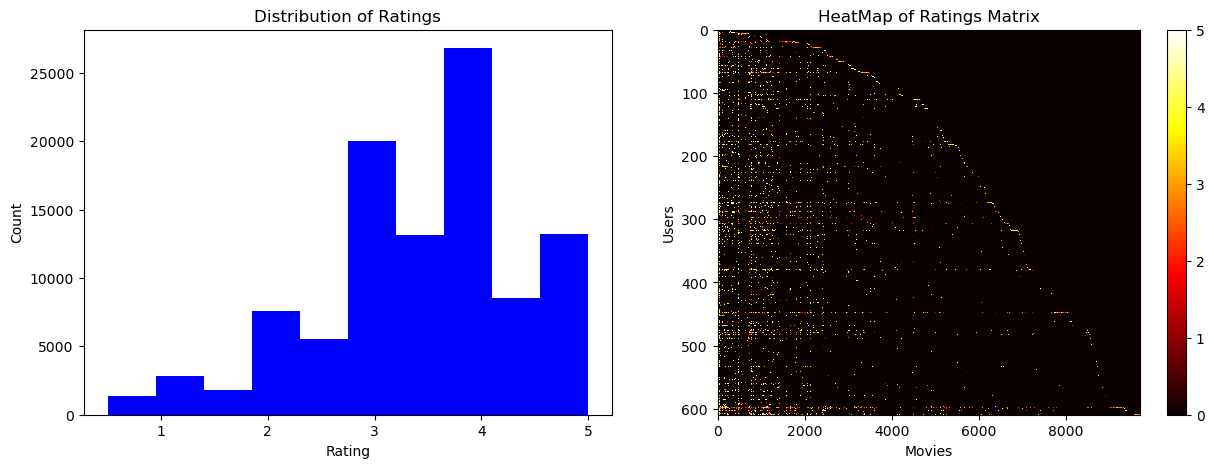

In [22]:
# 2 plot figure
fig = plt.figure(figsize=(15, 5))

# plot histogram of ratings
ax1 = fig.add_subplot(121)

ax1.hist(df['rating'], bins=10, color='blue')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Ratings')

# plot heatmap of ratings
ax2 = fig.add_subplot(122)

ax2.imshow(ratings, cmap='hot', interpolation='nearest', aspect='auto')
ax2.set_xlabel('Movies')
ax2.set_ylabel('Users')
ax2.set_title('HeatMap of Ratings Matrix')

# add a colorbar to the heatmap
plt.colorbar(ax2.imshow(ratings, cmap='hot', interpolation='nearest', aspect='auto'))

plt.show()

As we can see, the distribution of ratings is skewed towards higher ratings. This is expected, since users are more likely to rate movies they like.

The heatmap of the ratings matrix shows us that the first 2000-2500 movies have been rated by most users, while the rest of the movies have been rated by a small number of users. Thus we can conclude that the matrix is sparse, with many gaps in the data. This is also expected, since each user has not rated all the movies. We will use this information to determine the number of latent factors to use in our SVD model.

At this point, we have to discuss the way we handle the missing values. As of right now, we replace missing data points with 0. However, when talking about the accuracy of the model, this means that we treat the missing values as if the user has rated the movie with 0. This is not the best approach, since we don't know if the user has actually seen the movie or not. A better approach would be to replace the missing values with the average rating of the movie, or the average rating of the user. However, this would require more computation and more memory, so we will stick with the 0s for now.

 **Data interpretation using SVD**
---

Singular Value Decomposition (SVD) is a matrix factorization technique that is used to decompose a matrix into three other matrices. The three matrices are U, S, and V. The matrix U represents the relationship between users and latent features. The matrix V represents the relationship between movies and latent features. The matrix S represents the strength of each latent feature. The SVD formula is as follows:

$$R = U \Sigma V^T$$

where $R$ $(m,n)$ is the user-movie matrix, $U$ $(m,m)$ is the user-latent feature matrix, $\Sigma$ $(m,n)$ is the diagonal matrix of singular values (strength of each latent feature), and $V^T$ $(n,n)$ is the movie-latent feature matrix.

In general, and especially in our case where the number of users is much smaller than the number of movies(610 << 9274), calculating the full SVD is computationally expensive, and is thus usually avoided. We can instead calculate the [thin SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Reduced_SVDs). The thin SVD formula is as follows:

\begin{equation}
R = U_k \Sigma_k V_k^T \quad \text{, } k = \min(m,n)
\end{equation}

where $U_k$ $(m,k)$ is the user-latent feature matrix, $\Sigma_k$ $(k,k)$ is the diagonal matrix of singular values (strength of each latent feature), and $V_k^T$ $(k,n)$ is the movie-latent feature matrix.

The way the thin SVD is calculated is quite simple. We perform eigendecomposition on the $RR^T$ matrix, which has a $(610,610)$ shape, and we get the eigenvectors and eigenvalues of the matrix. The eigenvectors are the columns of $U$, and the eigenvalues are the diagonal elements of $\Sigma_k$. We completely skip calculating the $V_k^T$ matrix, since its very computationaly expensive. We can instead, use a bit of linear algebra to identify the relationship between the $RR^T$ and $R^TR$ eigenvectors:

Let $u$ be an eigenvector of $RR^T$ with eigenvalue $\lambda$. Then we have:

\begin{equation}
RR^Tu = \lambda u
\end{equation}
\begin{equation}
R^T(RR^Tu) = R^T \lambda u
\end{equation}
\begin{equation}
(R^TR)R^Tu = \lambda (R^T  u)
\end{equation}

In other words, if $u$ is an eigenvector of $RR^T$, then $R^Tu$ is an eigenvector of $R^TR$ with the same eigenvalue $\lambda$. This means that we can calculate the eigenvectors of $R^TR$ by multiplying the eigenvectors of $RR^T$ with $R^T$ on the left. This is much faster than calculating the eigenvectors of $R^TR$ directly, since $R^TR$ is a $(9274,9274)$ matrix.

In [68]:
def custom_svd(matrix):

    w = matrix.dot(matrix.T) / (matrix.shape[1] - 1)

    # eigenvalues and eigenvectors of w
    # we know w is symmetric, so we use eigh
    eigenvalues, eigenvectors = np.linalg.eigh(w)

    # sort eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]

    # sort eigenvectors according to eigenvalues
    eigenvectors = eigenvectors[:,idx]

    # calculate the singular values
    # take the abs value to avoid calculating errors near 0
    singular_values = np.sqrt(np.abs(eigenvalues))

    # eigen vectors are columns of U
    _U = eigenvectors

    # calculate Vt
    _V = matrix.T.dot(_U) / singular_values

    _Vt = _V.T

    return _U, singular_values, _Vt

In [103]:
# time the custom_svd function
start = time.time()

# calculate the svd of the ratings matrix
U, s, Vt = custom_svd(ratings)

end = time.time()

# print matrices shapes
print(f"U shape: {U.shape} | s shape: {s.shape} | V shape: {Vt.shape}")
print(f"Time taken to run custom_svd: {end-start} seconds\n")

# reconstruct the ratings matrix, to check if we are correct
ratings_reconstructed = U @ np.diag(s) @ Vt

# use np.allclose to check if the reconstructed matrix is close to the original matrix
print(f"Is reconstructed matrix \"close\" to original:{np.allclose(ratings, ratings_reconstructed)}\n")

U shape: (610, 610) | s shape: (610,) | V shape: (610, 9724)
Time taken to run custom_svd: 0.2077498435974121 seconds

Is reconstructed matrix "close" to original:True



We can see that the reconstructed matrix is the same as the original matrix, with a very small margin of error due to calculations, so we can be confident that our SVD is correct. Let's also use numpy's and scipy's, built-in SVD function to double-check our results, and compare their execution times.

In [25]:
# use svd of numpy to get U, s, Vt

# time the svd function
start = time.time()

# calculate the svd of the ratings matrix
__U, __s, __V = np.linalg.svd(ratings, full_matrices=False)

end = time.time()


# reconstruct the ratings matrix, to check if we are correct
ratings_reconstructed_np = __U.dot(np.diag(__s)).dot(__V)


# print matrices shapes
print("### numpy svd ###")
print(f"U shape: {__U.shape} | s shape: {np.diag(__s).shape} | V shape: {__V.shape}")
print(f"Time taken to run np.linalg.svd: {end-start} seconds")

# use np.allclose to check if the reconstructed matrix is close to the original matrix
print(f"Is reconstructed matrix \"close\" to original:{np.allclose(ratings, ratings_reconstructed_np)}")


### numpy svd ###
U shape: (610, 610) | s shape: (610, 610) | V shape: (610, 9724)
Time taken to run np.linalg.svd: 2.955000162124634 seconds
Is reconstructed matrix "close" to original:True


In [26]:
# time the svd function
start = time.time()

# calculate the svd of the ratings matrix, with scipy
scipy_svd = linalg.svd(ratings, full_matrices=False)

end = time.time()

# print matrices shapes
print("### scipy svd ###")
print(f"U shape: {scipy_svd[0].shape} | s shape: {scipy_svd[1].shape} | V shape: {scipy_svd[2].shape}")
print(f"Time taken to run scipy.linalg.svd: {end-start} seconds")

# reconstruct the ratings matrix, to check if we are correct
ratings_reconstructed_scipy = scipy_svd[0].dot(np.diag(scipy_svd[1])).dot(scipy_svd[2])

# use np.allclose to check if the reconstructed matrix is close to the original matrix
print(f"Is custom reconstruction \"close\" to scipy's:{np.allclose(ratings_reconstructed, ratings_reconstructed_scipy)}")


### scipy svd ###
U shape: (610, 610) | s shape: (610,) | V shape: (610, 9724)
Time taken to run scipy.linalg.svd: 1.9894192218780518 seconds
Is custom reconstruction "close" to scipy's:True


We are now sure, that our result is correct. We should also note, that our custom implementation is much faster than both implementations, even when we pass the argument full_matrices=False, which also calculates the reduced SVD.

We can now proceed with the interpretation of the results. We will start by examining the singular values, and how they contribute to the total energy of the dataset.

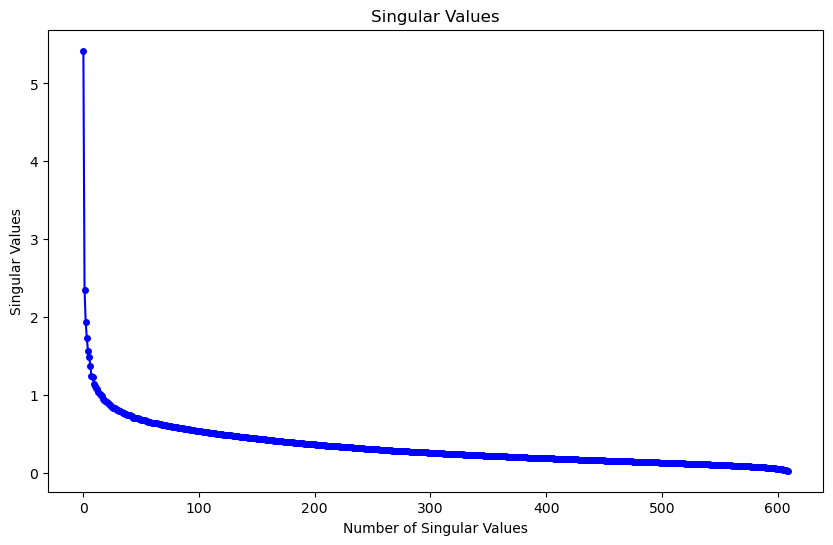

In [27]:
# create a 1 plot figure
fig = plt.figure(figsize=(10, 6))

# plot the singular values, on the center of the figure
ax1 = fig.add_subplot(111)
ax1.plot(s, marker='o', linestyle='-', color='b', markersize=4)
ax1.set_title('Singular Values')
ax1.set_xlabel('Number of Singular Values')
ax1.set_ylabel('Singular Values')

plt.show()

As we can observe, the first 100 singular values are much larger than the rest. This means that the first 100 latent features are much more important than the rest. We can use this information to reduce the dimensionality of the dataset, and only keep the first most significant latent features. This will allow us to reduce the size of the dataset, while preserving the most significant features.

Instead of truncating the features based on an arbitrary number, we can define an accuracy threshold, and keep the features that contribute to that threshold. For example, we can keep the first k features that contribute to 90% of the total energy of the dataset. This will allow us to reduce the dimensionality of the dataset, while preserving the most important features.

Number of singular values to retain 90.0% energy: 240


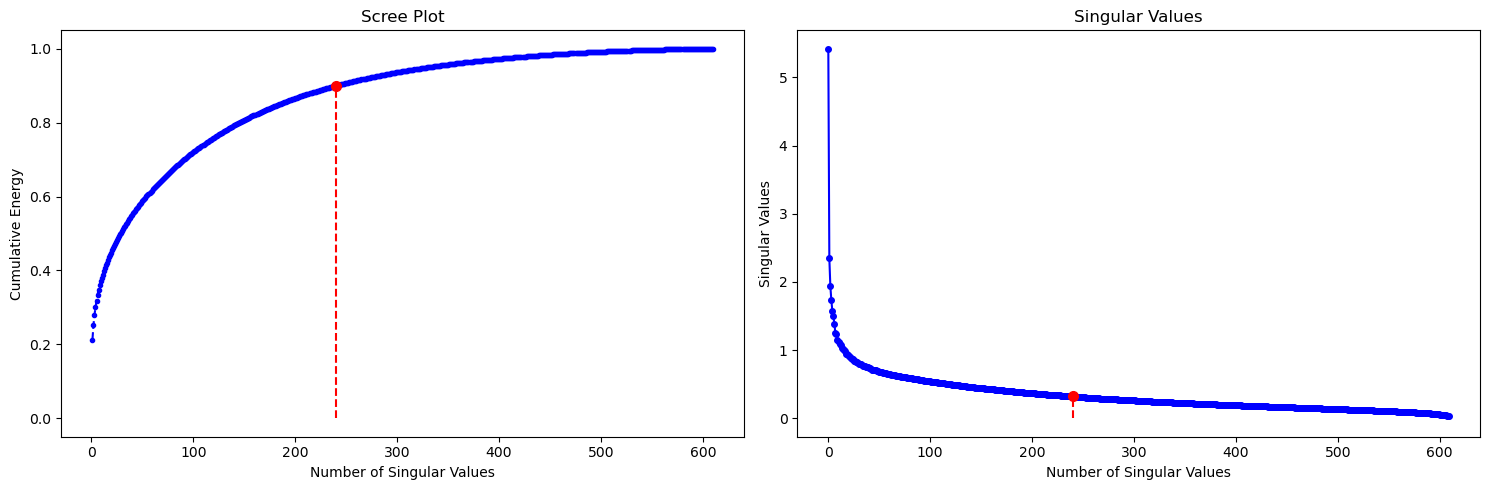

In [28]:
# Define the desired percentage of total energy to be retained (e.g., 90%)
desired_percentage = 0.9

# Calculate cumulative energy as before
cumulative_energy = np.cumsum(s**2) / np.sum(s**2)

# Find the index where the cumulative energy exceeds or equals the desired percentage
index_to_retain = np.argmax(cumulative_energy >= desired_percentage) + 1

print(f"Number of singular values to retain {desired_percentage*100}% energy: {index_to_retain}")

# plot the cumulative energy
pf.plot_energy_singvals(s, cumulative_energy, index_to_retain)

We should also take a look into the U and V matrices, to see if we can find any patterns or trends.

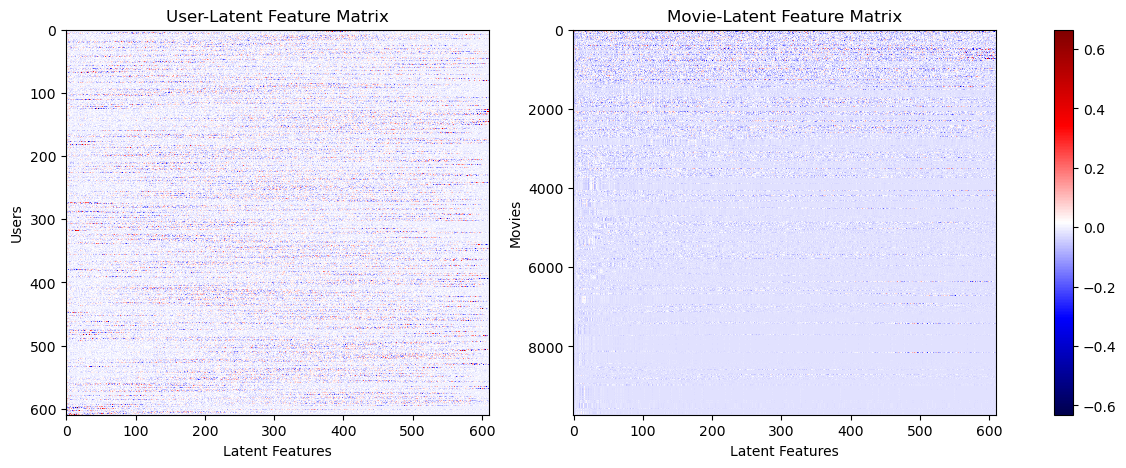

In [29]:
pf.plot_U_V(U, Vt)

On the User-Latent plot, we can not detect any patterns or trends, each user seems to contribute to all the latent features. This may be because, we treat the missing values as 0s, which in theory can explain the uniformity that we observe. If we had replaced the missing values with the average rating of the user, we could potentially see a different plot.

On the Movie-Latent plot, we can see that because the first 2000-2500 movies were the most rated ones, they are the ones that have the most significant latent features. The rest of the movies have very small latent features, which means that they are not very important. This is also the reason why the user-latent plot is more uniform, since each user has rated a different number of movies, and thus the latent features are more evenly distributed.



   ## **Interpreting the User latent features**
Let's take a deeper look on the User latent matrix, and see if the reason we see no pattern, is because of the missing values.

We will replace the missing values with 3 different approaches:

1. Replace missing values with the average rating of the movie
2. Replace missing values with the average rating of the user
3. Replace missing values with a combination of the first 2 approaches

In [30]:
# replacing with movie mean
ratings_movie_mean, movies_mean = cf.replace_missing_with_movie_mean(ratings)
U_movie_mean, s_movie_mean, Vt_movie_mean = custom_svd(ratings_movie_mean)

# replacing with user mean
ratings_user_mean, users_mean = cf.replace_missing_with_user_mean(ratings)
U_user_mean, s_user_mean, Vt_user_mean = custom_svd(ratings_user_mean)

# replacing with a combination of both
a = 0.5
ratings_combined_mean = cf.replace_missing_with_combined_mean(ratings, a, users_mean, movies_mean)
U_combined_mean, s_combined_mean, Vt_combined_mean = custom_svd(ratings_combined_mean)

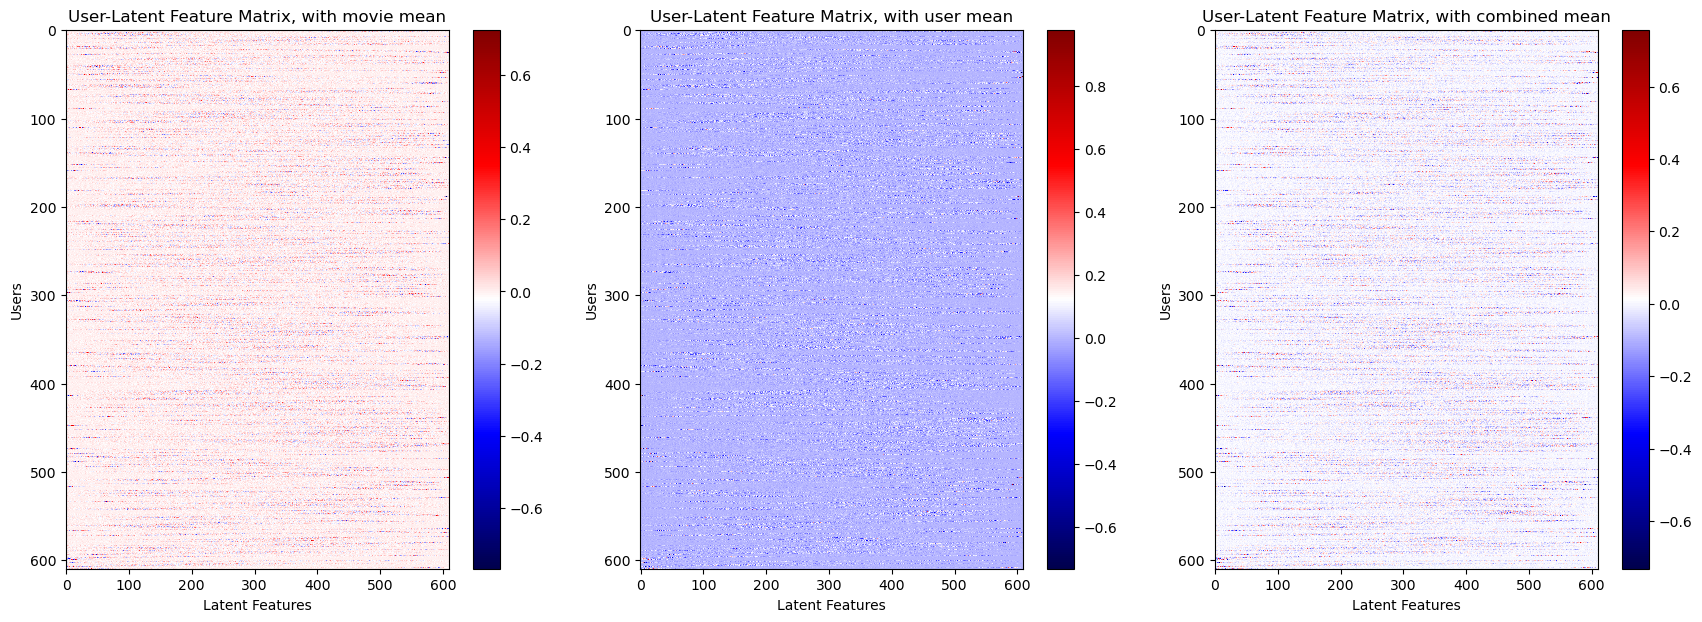

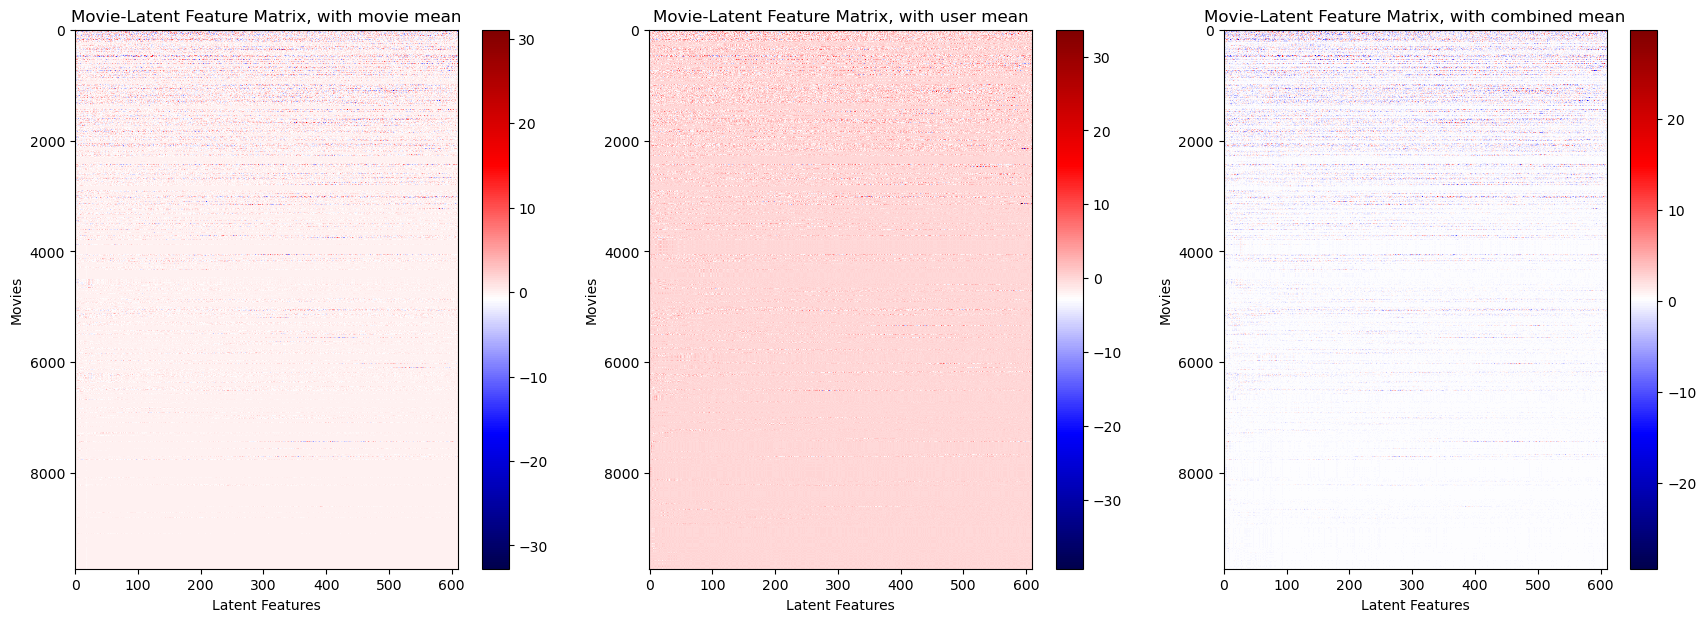

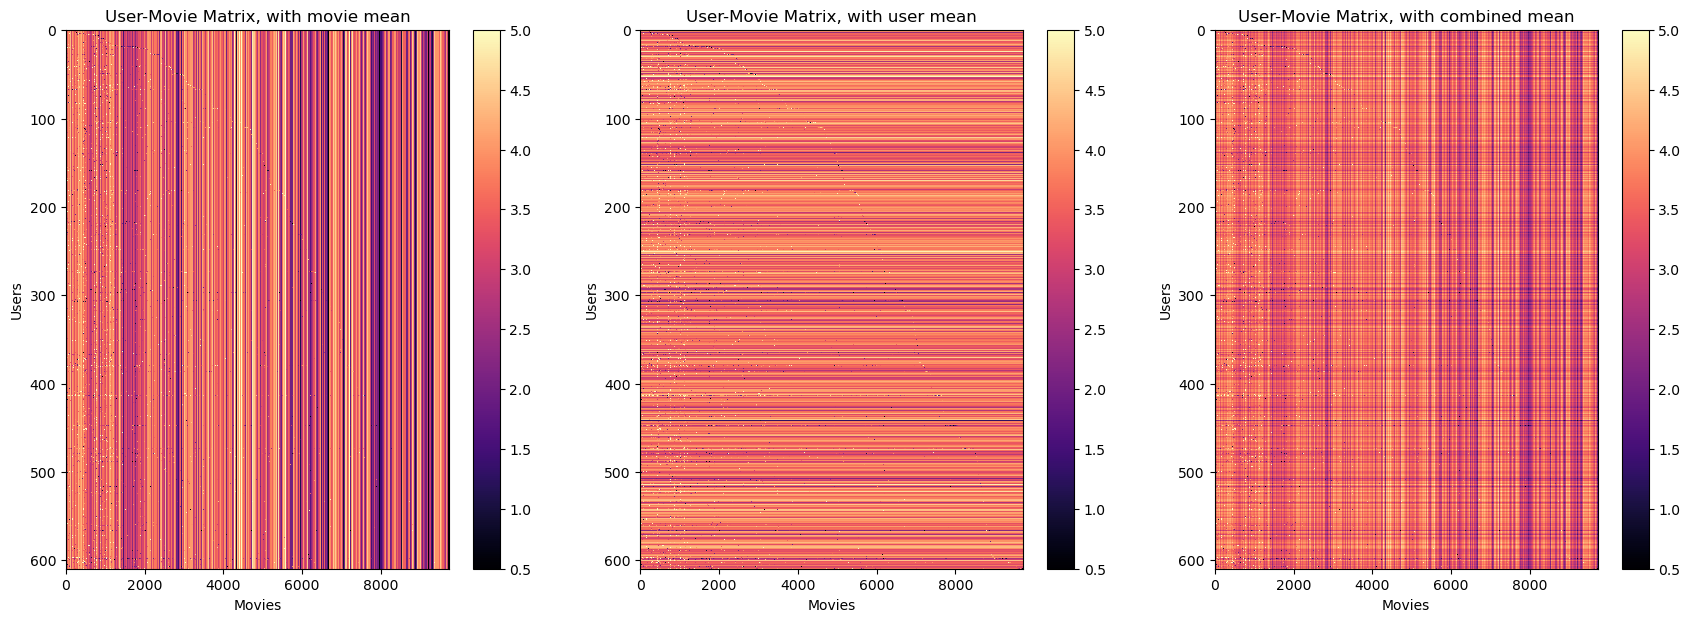

In [31]:
# pack the 3 different approaches into dictionaries
info1 = {'array': U_movie_mean, 'title': 'User-Latent Feature Matrix, with movie mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Users'}
info2 = {'array': U_user_mean, 'title': 'User-Latent Feature Matrix, with user mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Users'}
info3 = {'array': U_combined_mean, 'title': 'User-Latent Feature Matrix, with combined mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Users'}

# plot the 3 different approaches
pf.plot_heatmaps(info1, info2, info3, 'seismic')

# pack the 3 different approaches into dictionaries
info1 = {'array': Vt_movie_mean, 'title': 'Movie-Latent Feature Matrix, with movie mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Movies'}
info2 = {'array': Vt_user_mean, 'title': 'Movie-Latent Feature Matrix, with user mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Movies'}
info3 = {'array': Vt_combined_mean, 'title': 'Movie-Latent Feature Matrix, with combined mean', 'axis1_name': 'Latent Features', 'axis2_name': 'Movies'}

# plot the 3 different approaches
pf.plot_heatmaps(info1, info2, info3, 'seismic')

# plot the 3 ratings matrices

# pack the 3 ratings
info1 = {'array': ratings_movie_mean, 'title': 'User-Movie Matrix, with movie mean', 'axis1_name': 'Movies', 'axis2_name': 'Users'}
info2 = {'array': ratings_user_mean, 'title': 'User-Movie Matrix, with user mean', 'axis1_name': 'Movies', 'axis2_name': 'Users'}
info3 = {'array': ratings_combined_mean, 'title': 'User-Movie Matrix, with combined mean', 'axis1_name': 'Movies', 'axis2_name': 'Users'}

# plot the 3 ratings matrices
pf.plot_heatmaps(info1, info2, info3, 'magma')

Looking at each plot, unfortunately we cannot detect any patters or trends. This suggests that the reason we see each user contributing to all the latent features, is not because of the missing values, but because of the nature of the dataset. Each user has rated a different number of movies, and thus the latent features are more evenly distributed.

Due to the vast sparsity of the dataset, each missing value replacement approach, seems to completely change the dataset. This is expected, since we are replacing a large number of values, and thus the dataset is changing significantly. This is also another significant reason why we cannot detect any patterns or trends in the U matrix.

A smarter approach would be, to truncate the dataset based on the most frequently rated movies, and perform these replacement procedures on the truncated dataset. This way, we would have a more dense dataset, and we would be able to detect patterns and trends in the U matrix.

We could take this a step further, by keeping the niche/unique movies rated by each user to better understand their preferences. This would allow us to recommend movies that may not be very popular, but are more likely to be enjoyed by the user.

Instead of trying to infer new movie ratings based solely on these 3 approaches alone, each predicted rating can be a part of a bigger and more sophisticated model, that takes into account similar users, similar movies and much more. Using these results as another variable which can affect the final predicted rating, will certainly result in a much more accurate model.

This specialized approach is out of the scope of this notebook, but it is definitely something to consider when working with this dataset.

   ## **Reducing Dimensionality using PCA**

Principal Component Analysis (PCA) is a dimensionality reduction technique that is used to transform a high-dimensional dataset into a lower-dimensional space, while preserving the most significant features. PCA is used to reduce the dimensionality of the dataset, and thus reduce the computational cost of the algorithms. PCA is also used to visualize high-dimensional datasets, by projecting them into a lower-dimensional space.

The standard procedure for calculating PCA is as follows:

1. Calculate the covariance matrix of the dataset
2. Calculate the eigenvalues and eigenvectors of the covariance matrix
3. Sort the eigenvalues in descending order
4. Sort the eigenvectors according to the sorted eigenvalues
5. The sorted eigenvectors are the principal directions of the dataset, and the sorted eigenvalues represent the amount of variance that each principal direction captures

This process looks alot like the formula for calculating the SVD, and that is because PCA is closely related to SVD. In fact, the eigenvectors of the covariance matrix are the same as the right singular vectors of the dataset. The eigenvalues of a covariance matrix $C$ are the squares of the singular values of the dataset. This means that we can use the SVD to calculate the PCA of the dataset, and thus save a lot of computational time.

The formula for calculating the PCA using the SVD is as follows:

The covariance matrix is given by:

\begin{equation}
C = \frac{1}{n-1}X^TX
\end{equation}

where $X$ is the dataset, and $n$ is the number of samples.

\begin{equation}
X = U \Sigma V^T
\end{equation}

\begin{equation}
X^TX = V \Sigma^T U^T U \Sigma V^T
\end{equation}

\begin{equation}
X^TX = V \Sigma^T \Sigma V^T
\end{equation}

\begin{equation}
X^TX = V \Sigma^2 V^T
\end{equation}

\begin{equation}
C = \frac{1}{n-1}V \Sigma^2 V^T
\end{equation}

But as we remember with the case of the SVD calculation, the resulting matrix would be of shape $(9274, 9274)$, which is very large. Instead, we can calculate the PCA of the transposed dataset, which would give us a $(610, 610)$ matrix. This is much faster, and we can use the same linear algebra trick as before, to calculate the eigenvectors of $X^TX$ $(610, 9724)$.

The transposed matrix, which is also known as the Gram Matrix is given by:

\begin{equation}
G = \frac{1}{n-1}XX^T
\end{equation}

\begin{equation}
XX^T = U \Sigma V^T V \Sigma U^T
\end{equation}

\begin{equation}
XX^T = U \Sigma^2 U^T
\end{equation}

\begin{equation}
G = \frac{1}{n-1}U \Sigma^2 U^T
\end{equation}

Placeholder text talking about the [kernel trick](https://stats.stackexchange.com/questions/7111/how-to-perform-pca-for-data-of-very-high-dimensionality/7144#7144) / [relationship between covariance and gram matrix eigendecomposition](https://stats.stackexchange.com/questions/192372/relationship-between-eigenvectors-of-frac1nxx-top-and-frac1nx-top)

In [32]:
def custom_pca(matrix, num_components=None):

    # #call svd of sklearn
    # svd_decomp = linalg.svd(matrix / matrix.shape[0], full_matrices=False)
    #
    # temp_U = svd_decomp[0]
    #
    # temp_V = svd_decomp[2].T
    #
    # temp_S = np.diag(svd_decomp[1])

    # calculate the svd of the ratings matrix
    temp_U, sigma, temp_V = custom_svd(matrix / (matrix.shape[0] - 1))

    temp_S = np.diag(sigma)

    # if m >= n calculate cov matrix
    if matrix.shape[0] >= matrix.shape[1]:
        #covariance
        w = (temp_V @ (temp_S @ (temp_S @ temp_V.T))) / (matrix.shape[0] - 1)
    else:
        #gram
        w = (temp_U @ (temp_S @ (temp_S @ temp_U.T)) ) / (matrix.shape[0] - 1)


    # calculate eigenvalues and eigenvectors of w matrix
    eigenvalues, eigenvectors = np.linalg.eigh(w)

    # sort eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]

    # sort eigenvectors according to eigenvalues
    eigenvectors = eigenvectors[:,idx]

    # if we used gram matrix, use the "kernel trick"
    if matrix.shape[0] < matrix.shape[1]:
        eigenvectors = (matrix.T @ eigenvectors) / np.sqrt(matrix.shape[0] * eigenvalues)

    # truncate eigenvectors according to num_components
    if num_components is not None:
        _components = eigenvectors[:, :num_components]
        _explained_variance = eigenvalues[:num_components] / np.sum(eigenvalues)
    else:
        _components = eigenvectors
        _explained_variance = eigenvalues / np.sum(eigenvalues)

    return _components, _explained_variance

In [101]:
ratings_std = (ratings - np.mean(ratings, axis=0))

# calculate the pca of the ratings matrix

# time the pca function
start = time.time()

# calculate the pca of the ratings matrix
components, explained_variance = custom_pca(ratings_std)
fit_ratings = ratings_std @ components

end = time.time()

# fit the ratings

# print matrices shapes
print( f"Components shape: {components.shape}, explained variance shape: {explained_variance.shape}")
print(f"Fit ratings shape: {fit_ratings.shape}")
print(f"Time taken to run custom_pca: {end-start} seconds\n")

Components shape: (9724, 610), explained variance shape: (610,)
Fit ratings shape: (610, 610)
Time taken to run custom_pca: 0.356548547744751 seconds



Let's also compare our function with sklearn's PCA function, and see if we get the same results.

In [34]:
from sklearn.decomposition import PCA

# call pca from sklearn
pca = PCA()

# time the pca function
start = time.time()

fit_ratings_sklearn = pca.fit_transform(ratings_std)

end = time.time()

print(f"Components shape: {pca.components_.shape}, explained variance shape: {pca.explained_variance_.shape}")
print(f"Fit ratings shape: {fit_ratings_sklearn.shape}")
print(f"Time taken to run sklearn.decomposition.PCA: {end-start} seconds")

Components shape: (610, 9724), explained variance shape: (610,)
Fit ratings shape: (610, 610)
Time taken to run sklearn.decomposition.PCA: 1.9671969413757324 seconds


Variance

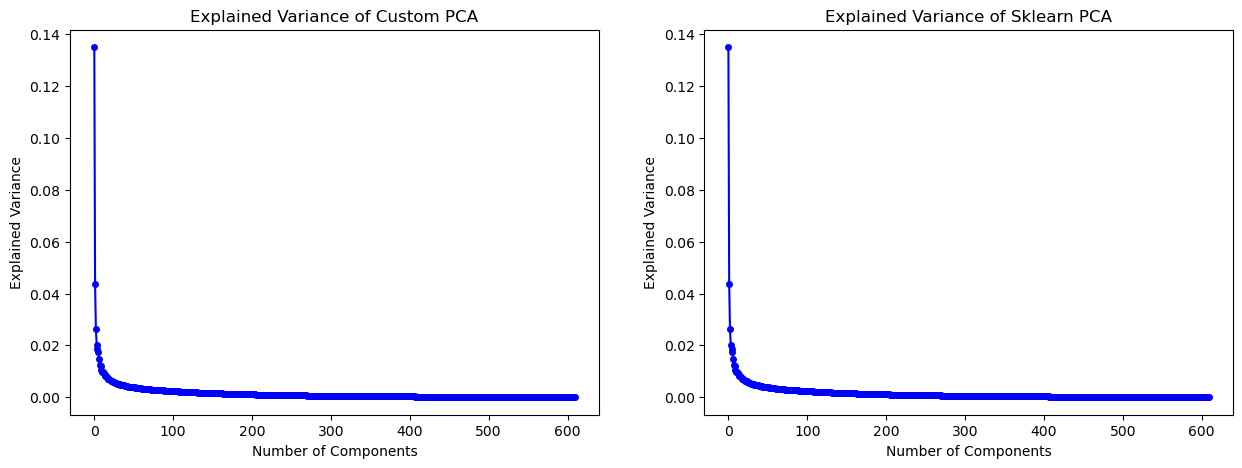

In [35]:
# create a 2 plot figure
fig = plt.figure(figsize=(15, 5))

# plot explained variance of custom and sklearn pca
ax1 = fig.add_subplot(121)
ax1.plot(explained_variance, marker='o', linestyle='-', color='b', markersize=4)
ax1.set_title('Explained Variance of Custom PCA')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance')

ax2 = fig.add_subplot(122)
ax2.plot(pca.explained_variance_ratio_, marker='o', linestyle='-', color='b', markersize=4)
ax2.set_title('Explained Variance of Sklearn PCA')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Explained Variance')

plt.show()

1-D and 2-D Component Plot, comparing our implementation to sklearn's

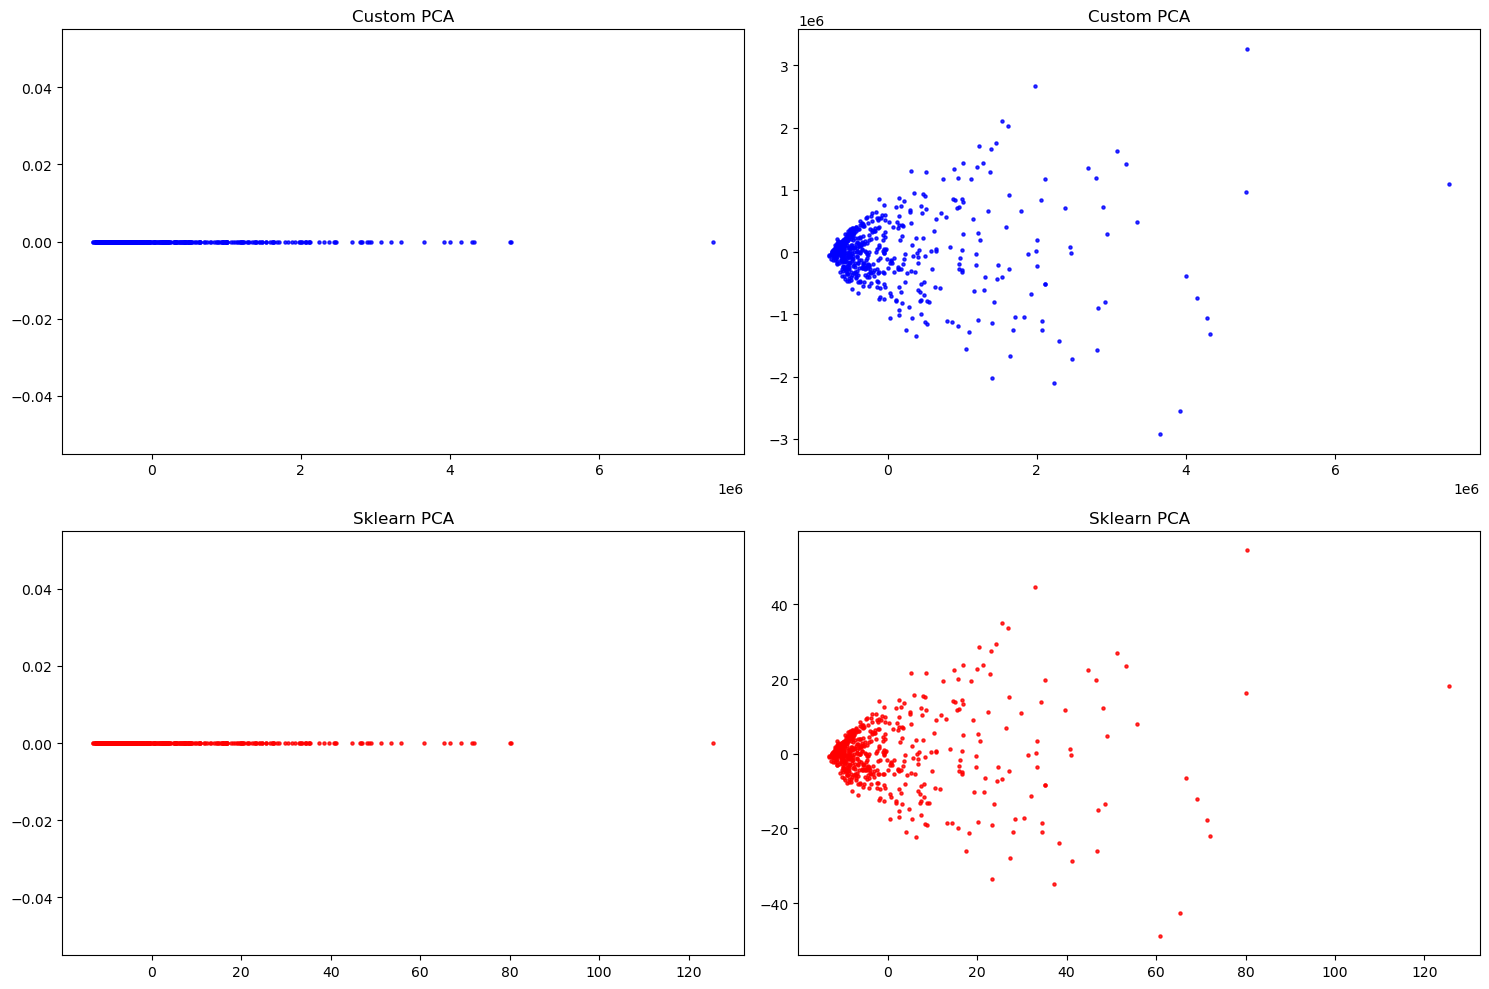

In [36]:
pf.plot_scatters(fit_ratings, fit_ratings_sklearn, 'Custom PCA', 'Sklearn PCA')

3-D Component Plot

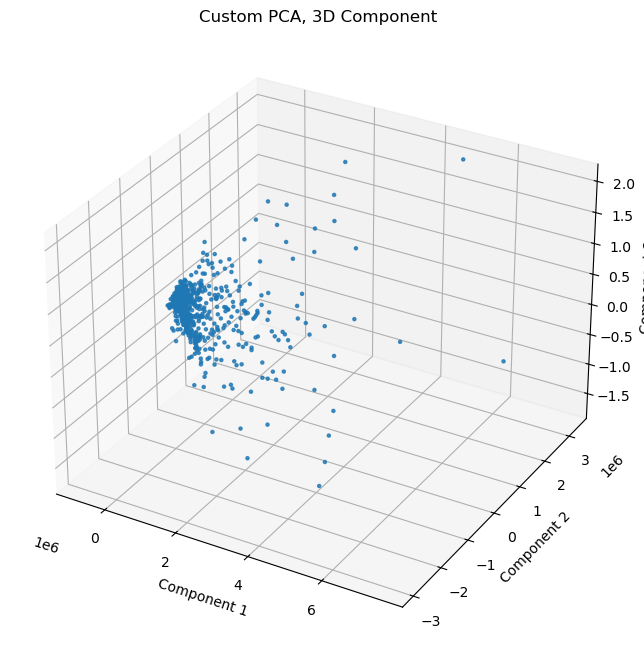

In [37]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(fit_ratings[:, 0], fit_ratings[:, 1], fit_ratings[:, 2], alpha=0.8, s=5)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Custom PCA, 3D Component')

plt.show()

We can see that our implementation is very similar to the sklearn implementantion, with the axes being scaled differently.

An observant reader may have noticed that, in the process of calculating the PCA using the SVD, we actually calculated the eigenvectors/eigenvalues of $AA^T$ twice, once in the SVD and once in the PCA. If we have calculated the SVD of a Matrix, we in fact have every component we need to create the PCA, without performing any more calculations.

More information about this can be found [here](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca), an excellent explanation given by amoeba.

Fast PCA time: 0.17807579040527344 seconds


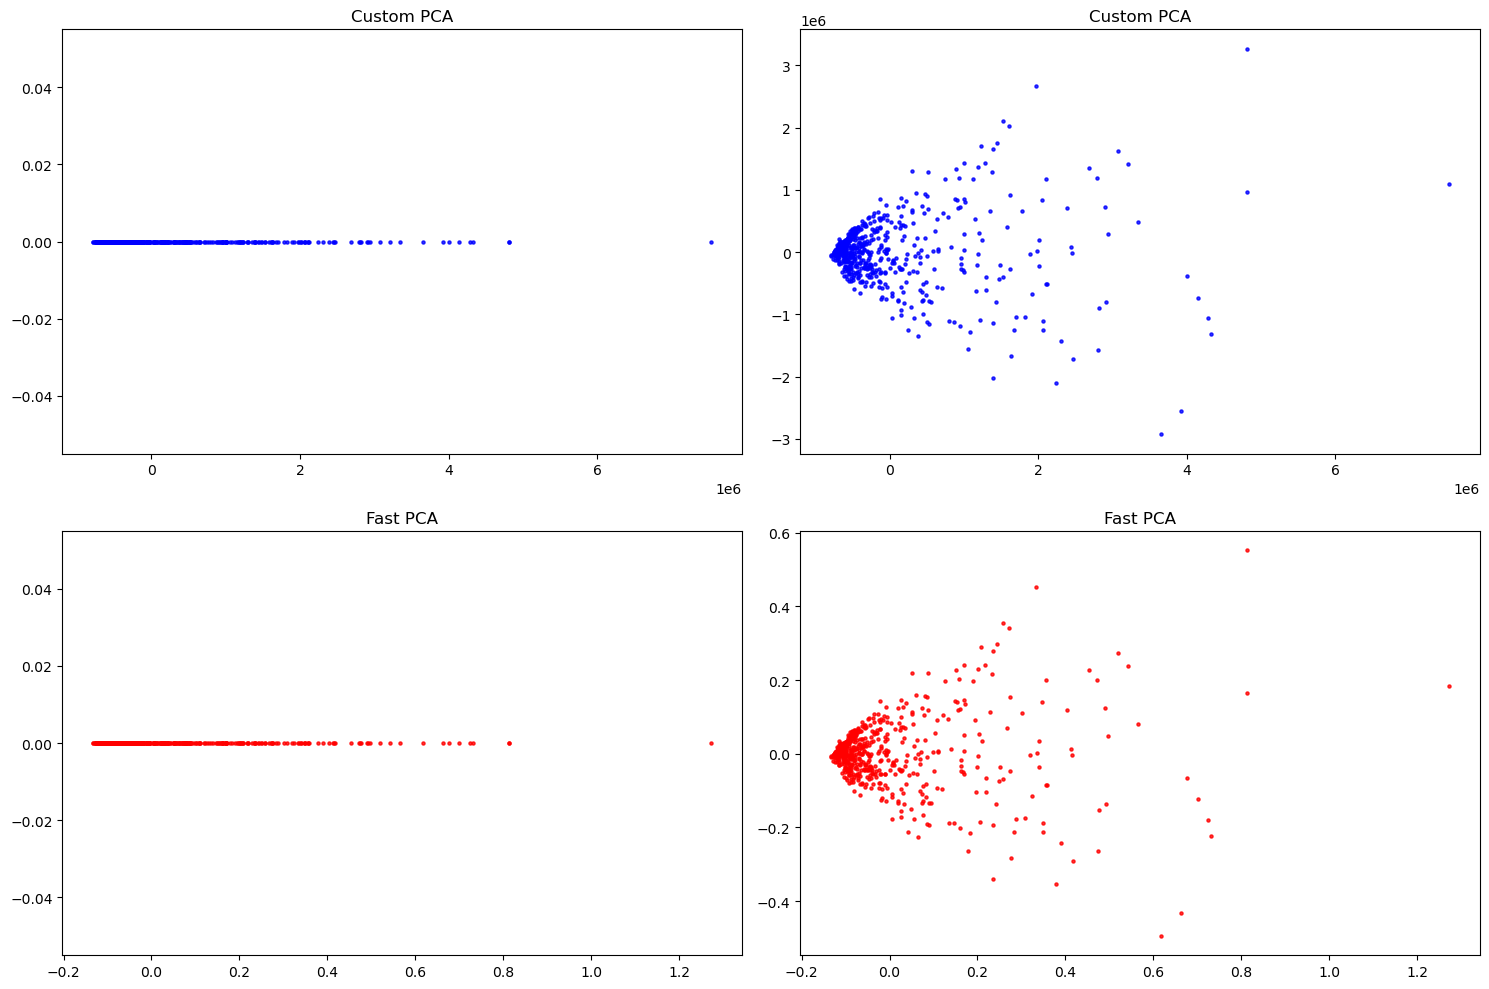

In [38]:
start = time.time()
# calculate the svd
U, s, Vt = custom_svd(ratings_std)

# Vt are the principal directions -> A @ Vt = principal components
# A @ Vt = ( U @ S @ Vt ) @ Vt = U @ S
# so U @ S = principal components
components_fast = U @ np.diag(s)

end = time.time()

print(f"Fast PCA time: {end-start} seconds")
# plot the comparison between first PCA and fast
pf.plot_scatters(fit_ratings, components_fast, 'Custom PCA', 'Fast PCA')

## **User Similarity via PCA Projections**

We can use the PCA projections to calculate the similarity between users. We will apply dimensionality reduction to a subset of the users, the training data, and then try to find the most similar users to a given user, the validation set. We then can use KNN on the reduced dataset, to quickly find the most similar users to a given user.

If we hadn't used PCA, we would have to calculate the similarity between each user, which would be very computationally expensive since each user has a total of 9724 features. Using PCA we can reduce the features to the first $k$ most important, and save a lot of computational time.

In [39]:
# split the ratings matrix randomly into train and validation sets
# 70% train, 30% validation
percentage = 0.7

# Set the seed for reproducibility
np.random.seed(42)

# Generate an array of 610 integers
all_integers = np.arange(0, ratings.shape[0])

# Shuffle the array randomly
np.random.shuffle(all_integers)

# Calculate the index to split at 70%
split_index = int(percentage * len(all_integers))

# Split the array into two variables
train_index = all_integers[:split_index]
val_index = all_integers[split_index:]

# split the ratings matrix into train and validation sets
train_users = ratings[train_index]
val_users = ratings[val_index]

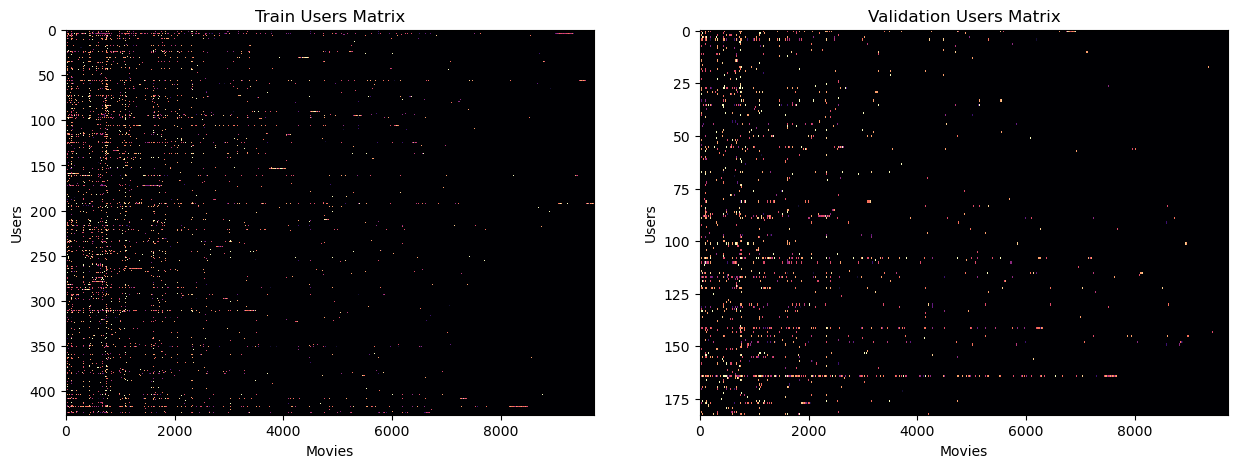

In [40]:
# create a 2 plot figure
fig = plt.figure(figsize=(15, 5))

# plot train_users matrix
ax1 = fig.add_subplot(121)
ax1.imshow(train_users, cmap='magma', interpolation='nearest', aspect='auto')
ax1.set_xlabel('Movies')
ax1.set_ylabel('Users')
ax1.set_title('Train Users Matrix')


# plot val_users matrix
ax2 = fig.add_subplot(122)
ax2.imshow(val_users, cmap='magma', interpolation='nearest', aspect='auto')
ax2.set_xlabel('Movies')
ax2.set_ylabel('Users')
ax2.set_title('Validation Users Matrix')

plt.show()

Let's apply PCA to the training data in order to reduce the dimensionality of the dataset, and then project the validation data onto the components of the training data.

As we show in the 3-D plot of the projection of the training data, the first 3 components capture a big part of the variance. The big downside of using just the first 3, is that there exists a very big cluster in the middle of the axis, meaning that 3 components are not enough to capture the variance of this subset, or that these users are very related.

We will instead reduce the dimensionality to the first 100 components, which will spread out the data more, and allow us to capture more variance. The sole reason we are doing this, is because we will sample a big portion of the nearest neighbors, using 2 distance methods, to provide the Spearman correlation a bigger sample size for each user, to be able to identify relationships for a bigger portion of the users.

In [41]:
# mean center the train_users matrix
train_users_std = (train_users - np.mean(train_users, axis=0))

components, explained_variance = custom_pca(train_users_std, num_components=240)

# print matrices shapes
print(f"components shape: {components.shape} | explained_variance shape: {explained_variance.shape}")

# fit the data
fit_train_users = np.dot(train_users_std, components)

components shape: (9724, 240) | explained_variance shape: (240,)


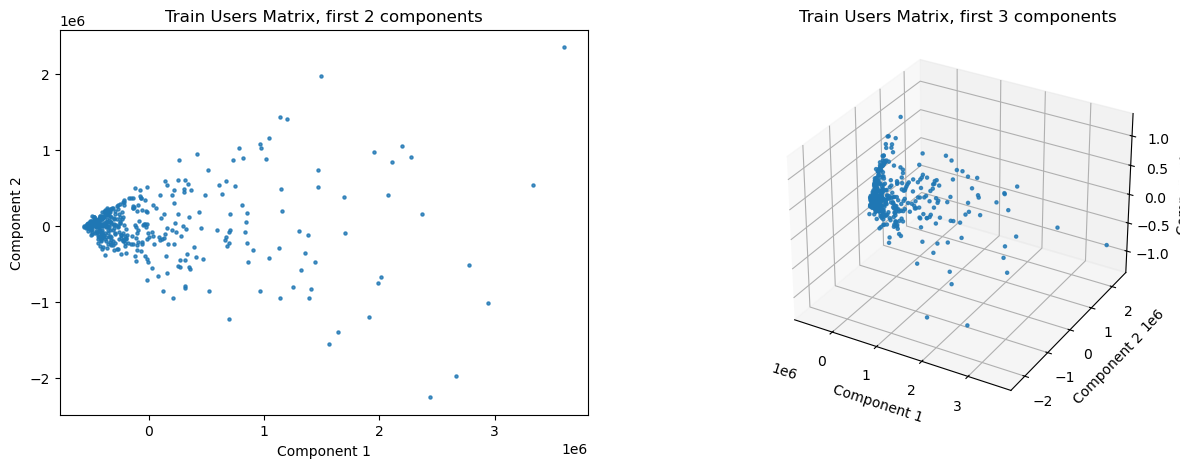

In [42]:
# create a 2 plot figure
fig = plt.figure(figsize=(15, 5))

# plot train_users matrix on first 2 components
ax1 = fig.add_subplot(121)
ax1.scatter(fit_train_users[:, 0], fit_train_users[:, 1], alpha=0.8, s=5)
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('Train Users Matrix, first 2 components')

# plot train_users matrix on first 3 components
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(fit_train_users[:, 0], fit_train_users[:, 1], fit_train_users[:, 2], alpha=0.8, s=5)
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_zlabel('Component 3')
ax2.set_title('Train Users Matrix, first 3 components')

plt.show()

Projecting the validation set onto the components of the training set

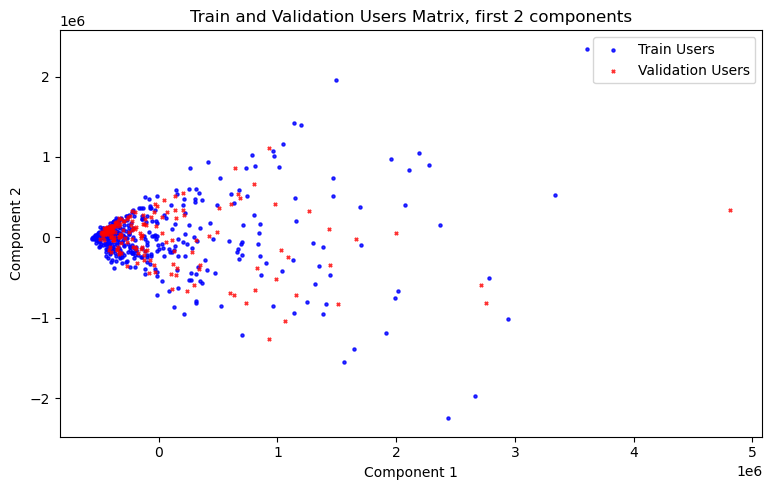

In [43]:
# project the validation set onto the components
val_users_std = (val_users - np.mean(val_users, axis=0))

fit_val_users = np.dot(val_users_std, components)

# create a 2 plot figure
fig = plt.figure(figsize=(15, 5))

# scatter plot with blue "o" for train users
ax1 = fig.add_subplot(121)
ax1.scatter(fit_train_users[:, 0], fit_train_users[:, 1], alpha=0.8, s=5, color='b', label='Train Users')

# scatter plot with red "x" for val users
ax1.scatter(fit_val_users[:, 0], fit_val_users[:, 1], alpha=0.8, s=5, color='r', label='Validation Users', marker='x')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('Train and Validation Users Matrix, first 2 components')

# add a legend
ax1.legend()

plt.tight_layout()
plt.show()

In [44]:
k = 25

# list that hold k nearest neighbors for each user
nearest_neighbors_eucl = []

for val_user in fit_val_users:
    # calculate the euclidean distance between the val_user and all the train_users
    distances = np.linalg.norm(fit_train_users - val_user, axis=1)

    # sort the distances in ascending order
    sorted_distances = np.argsort(distances)

    # get the k nearest neighbors
    k_nearest_neighbors = sorted_distances[:k]

    # append the k nearest neighbors to the list
    nearest_neighbors_eucl.append(k_nearest_neighbors)

# preprocess the array
nearest_neighbors_eucl = np.array(nearest_neighbors_eucl)
print(nearest_neighbors_eucl.shape)

(183, 25)


In [45]:
from scipy import  spatial

nearest_neighbors_cos = []

for val_user in fit_val_users:
    similarities = [1 - spatial.distance.cosine(val_user, train_user) for train_user in fit_train_users]

    nearest = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)[:k]

    nearest_neighbors_cos.append(nearest)

# drop second value of tuple
nearest_neighbors_cos = [list(map(lambda x: x[0], neighbor)) for neighbor in nearest_neighbors_cos]

# convert to numpy again
nearest_neighbors_cos = np.array(nearest_neighbors_cos)
print(nearest_neighbors_cos.shape)

(183, 25)


In [46]:
# for each val_user, find the union of potential similar users from euclidean and cosine methods

# list that holds the union of similar users
nearest_neighbors_union = []

for i in range(len(nearest_neighbors_eucl)):
    # find the union of the similar users
    union = np.union1d(nearest_neighbors_eucl[i], nearest_neighbors_cos[i])

    # append the union to the list
    nearest_neighbors_union.append(union)

print(nearest_neighbors_union[0])

[  1   3   6   7   8  10  14  17  20  23  28  30  33  34  37  42  55  56
  64  65  85  94  96  97 102 105 128 136 143 146 192 199 204 207 228 238
 254 264 281 293 311 336 351 358 382 386 416 421 424]



We have now calculated for each user in the validation set, their 25 nearest neighbours using 2 methods, euclidean distance and cosine similarity. We can now use these nearest neighbors to calculate the similarity between the users.

We have used a high number for the KNN, and in addition taken the union of them, to increase the sample size of potential similar users, since later on in the analysis we will filter them using the Spearman correlation coefficient.

If we had used just the 3 first components, we would see that the intersection of the 2 methods is very similar, for reasons we have explained above. If someone is interested in finding a stricter similarity measure, they could decrease the number of dimensions and use the intersection of the 2 methods. Reducing the $k$ parameter would also help narrow the results to just the strongly related users. The downside of this approach is that, the ending graph/model, would not be able to identify a relationship between all users, but rather a small subset of them.

Lets take a look at the first user in the validation set, and their nearest neighbor, and see how the ratings for movies they have both rated compare. Let also include a random user from the training set, to see how the ratings of the nearest neighbor compare to a random user.

Note: Due to increasing the dimensions so much, the first neighbor, is not similar. If you want to see a similar neighbor, change the k parameter to 5.

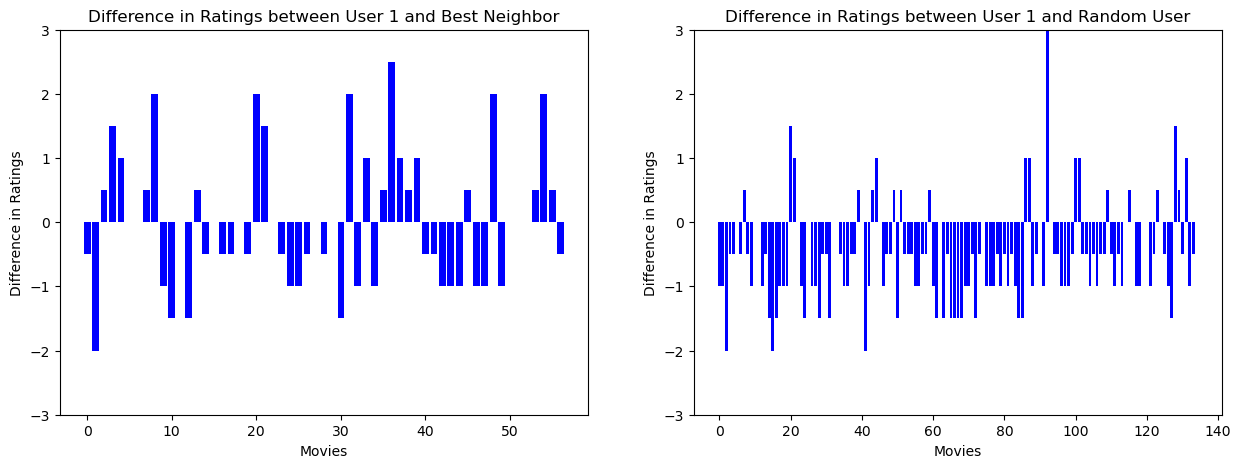

In [47]:
user1 = val_users[0]
best_neighbor = train_users[nearest_neighbors_eucl[0][0]]
random_user = train_users[10]


# find their intersection
intersection = np.intersect1d(np.nonzero(user1), np.nonzero(best_neighbor))
rand_intersection = np.intersect1d(np.nonzero(user1), np.nonzero(random_user))

# keep only the ratings of the intersection
user1_inter = user1[intersection]
best_neighbor = best_neighbor[intersection]

rand_user1 = user1[rand_intersection]
random_user = random_user[rand_intersection]

difference = user1_inter - best_neighbor
rand_difference = rand_user1 - random_user

# create a 2 plot figure, to display barplots of difference, rand_difference
fig = plt.figure(figsize=(15, 5))

# plot difference
ax1 = fig.add_subplot(121)
ax1.bar(np.arange(len(difference)), difference, color='b')
ax1.set_xlabel('Movies')
ax1.set_ylabel('Difference in Ratings')
ax1.set_title('Difference in Ratings between User 1 and Best Neighbor')
ax1.set_ylim([-3, 3])

# plot rand_difference
ax2 = fig.add_subplot(122)
ax2.bar(np.arange(len(rand_difference)), rand_difference, color='b')
ax2.set_xlabel('Movies')
ax2.set_ylabel('Difference in Ratings')
ax2.set_title('Difference in Ratings between User 1 and Random User')
ax2.set_ylim([-3, 3])

plt.show()

# **Filtering neighbors using the Spearman Rank Correlation Coefficient**

We have calculated the nearest neighbors for each user in the validation set, using 2 different methods, euclidean distance and cosine similarity. We can now analyze the relationships between each validation user and their nearest neighbor, using the [Spearman Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

The Spearman Correlation Coefficient is a measure of the correlation between 2 variables. It is a measure of the monotonicity of the relationship between the variables, and not the linear relationship.

What this allows us, is to quantify how strongly correlated each relationship is, and based on a threshold, filter our relationships that are loosely correlated. Whilist this will dramatically reduce the number of relationships we can analyze, it will also increase the accuracy of the model, since we will be able to identify the relationships that are statistically significant.

Lets apply this analysis to the example we talked about above. We will calculate the spearman correlation coefficient between the user and their nearest neighbor, and between the user and a random user.

In [48]:
user1 = val_users[0]
best_neighbor = train_users[nearest_neighbors_eucl[0][0]]
random_user = train_users[10]

# calculate the spearman correlation coefficient between the user and their nearest neighbor
spearman_coeff = cf.similarity_spearman(user1, best_neighbor)
print(f"User and nearest neighbor: corr:{spearman_coeff[0]}, p-value:{spearman_coeff[1]}")

# calculate the spearman correlation coefficient between the user and a random user
spearman_coeff = cf.similarity_spearman(user1, random_user)
print(f"User and random user: corr:{spearman_coeff[0]}, p-value:{spearman_coeff[1]}")


User and nearest neighbor: corr:0.0330952984740668, p-value:0.8069246828402715
User and random user: corr:0.19015973040639, p-value:0.027167067432208966


We observe that the correlation coefficient between the user and their nearest neighbor is higher than the correlation coefficient between the user and a random user, but more importantly, the p-value is much lower. This means that the correlation between the user and their nearest neighbor is statistically significant, and thus we can reject the null hypothesis.

We should clarify something about the p-value of the selected user's and the random sample's p-value. Even though the p-value is very low, smaller than 0.05, that does not imply that their ratings are correlated. The p-value is a measure of the statistical significance of the correlation, and not the correlation itself. In other words, the p-value tells us how sure we can be, about the probability of the correlation coefficient actually having the current value.

If we wanted to be more rigorous with our calculation of the accuracy of the model, we could calculate the mean p-value that any 2 random users have, and then compare it to the p-value between the user and their nearest neighbor. This would give us a more accurate measure of the statistical significance of the correlation between the user and their nearest neighbor.

Let's now calculate this metric, for all the users in the validation set, for both the euclidean distance and the cosine similarity.

For each validation user we will,
 1. Calculate the spearman correlation coefficient for all $k$ nearest neighbours,
        We will use the indexes of the union of both euclidean and cosine nearest neighbors
 2. Keep only the similar users that have a correlation coefficient greater than 0.5, a p-value less than 0.05 and at least 4 movies in common.
 3. Construct a dictionary, where the key is the index of the train user, and the value is a set of {corrcoef, p-value}
 4. Append the dictionary to a list, which will hold all the best neighbors for all the validation users


In [49]:
results = cf.select_best_neighbors(val_users, train_users, nearest_neighbors_union, corr_threshold=0.5, p_value_threshold=0.05, min_common_elements=5, full_results=False)

print(results[:30])

C:\Users\nikba\anaconda3\envs\pythonProject4\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[[204], [155, 359, 418], [], [126, 357, 370], [416], [], [329, 394], [13], [369, 398], [263], [], [91, 126, 188], [], [], [], [336], [], [], [62, 204, 373, 416], [76, 390], [], [], [], [156, 274, 406], [44, 63], [207, 345, 366], [], [188], [303, 398, 422], []]


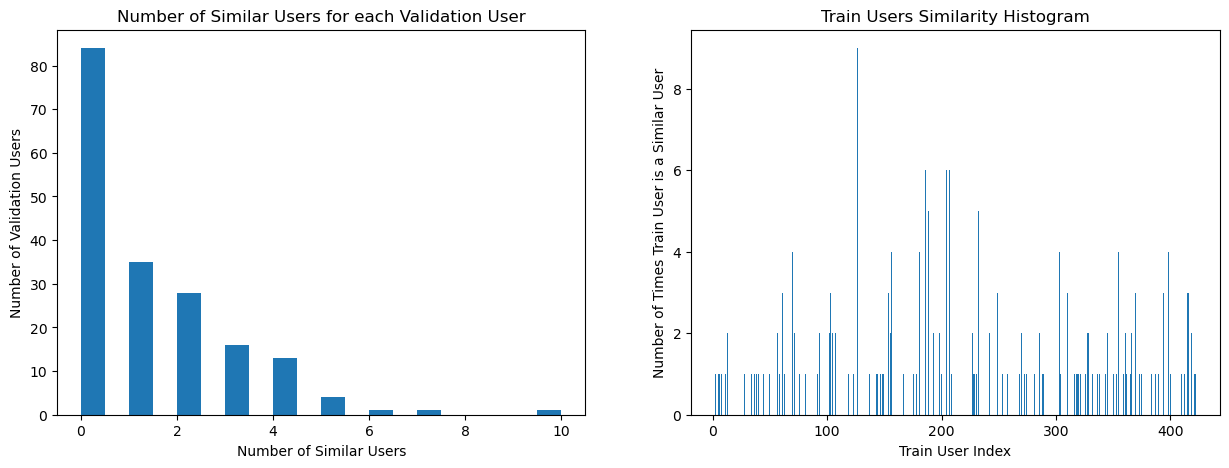

In [50]:
# create a 2 plot figure
fig = plt.figure(figsize=(15, 5))

# plot the number of similar users for each validation user
ax1 = fig.add_subplot(121)
ax1.hist([len(result) for result in results], bins=20)
ax1.set_xlabel('Number of Similar Users')
ax1.set_ylabel('Number of Validation Users')
ax1.set_title('Number of Similar Users for each Validation User')

# plot the number of times a train user is a similar user for a validation user
ax2 = fig.add_subplot(122)
ax2.hist([train_user_index for result in results for train_user_index in result], bins=610)
ax2.set_xlabel('Train User Index')
ax2.set_ylabel('Number of Times Train User is a Similar User')
ax2.set_title('Train Users Similarity Histogram')

plt.show()

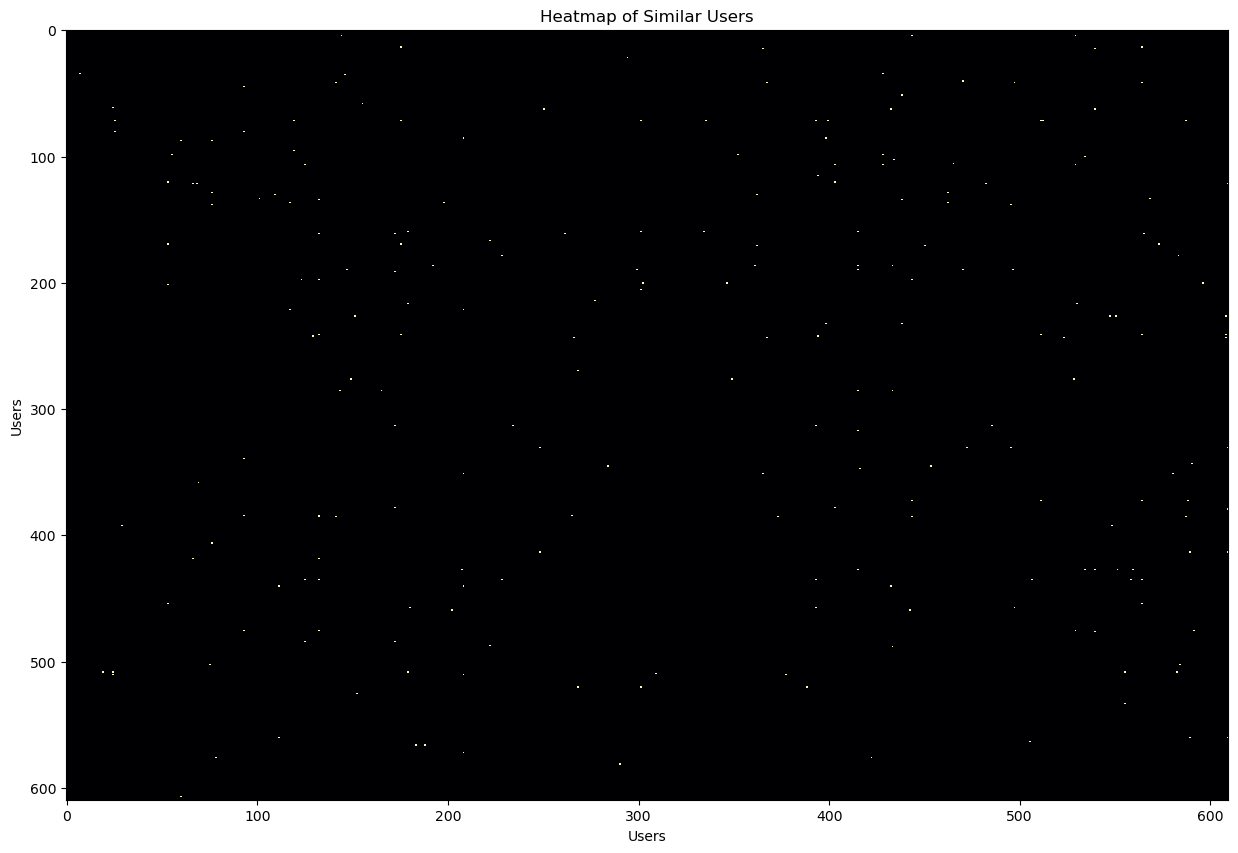

In [51]:
# create a heatmap of the results
# create a 2d array of zeros
heatmap = np.zeros((610, 610))

# for each validation user
for val_user_index, result in enumerate(results):
    # for each similar user
    for train_user_index in result:

        # find the true index of the validation user and the similar user
        true_val_index = val_index[val_user_index]
        true_train_index = train_index[train_user_index]

        # add 1 to the heatmap
        heatmap[true_val_index, true_train_index] += 1

# plot the heatmap
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.imshow(heatmap, cmap='magma', interpolation='nearest', aspect='auto')
ax.set_xlabel('Users')
ax.set_ylabel('Users')
ax.set_title('Heatmap of Similar Users')

plt.show()

Because the dataset is so sparse, we observe that the heatmap is mostly black, with a few white spots. This means that there are only a few users that are similar to each other, and most users are not similar to each other, at least in the context of this analysis.

Since we are dealing with such sparse relationships, we can draw a network graph of the results, to better visualize the relationships between the users.

In [52]:
# find all train users that meet the criteria, for each val_user
results = cf.select_best_neighbors(val_users, train_users, nearest_neighbors_union, corr_threshold=0.7, p_value_threshold=0.05, min_common_elements=5, full_results=False)
# create a graph
G = cf.create_graph(val_users, train_users, val_index, train_index, results)

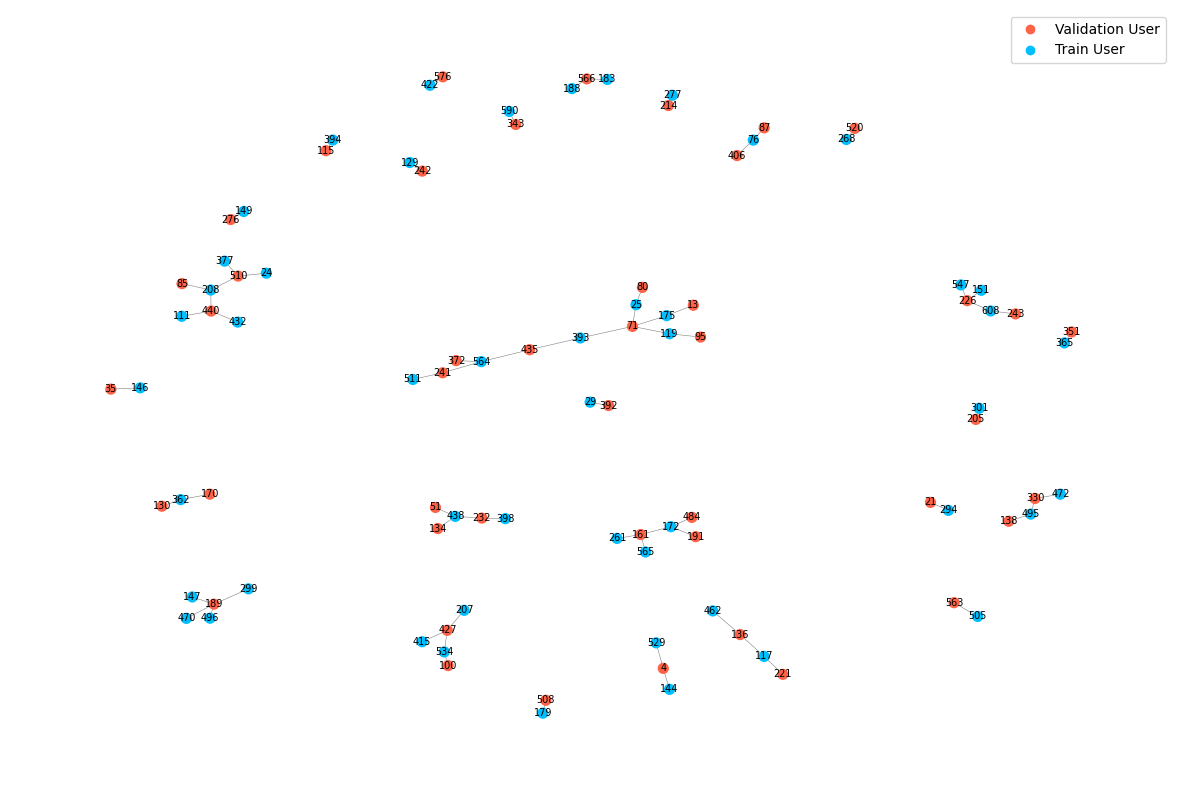

In [53]:
# plot the graph
pf.plotGraph(G, val_index)

SignificanceResult(statistic=0.9365079365079364, pvalue=6.582277999082316e-05)
Ratio of movies with difference smaller than 0.5: 10.0%


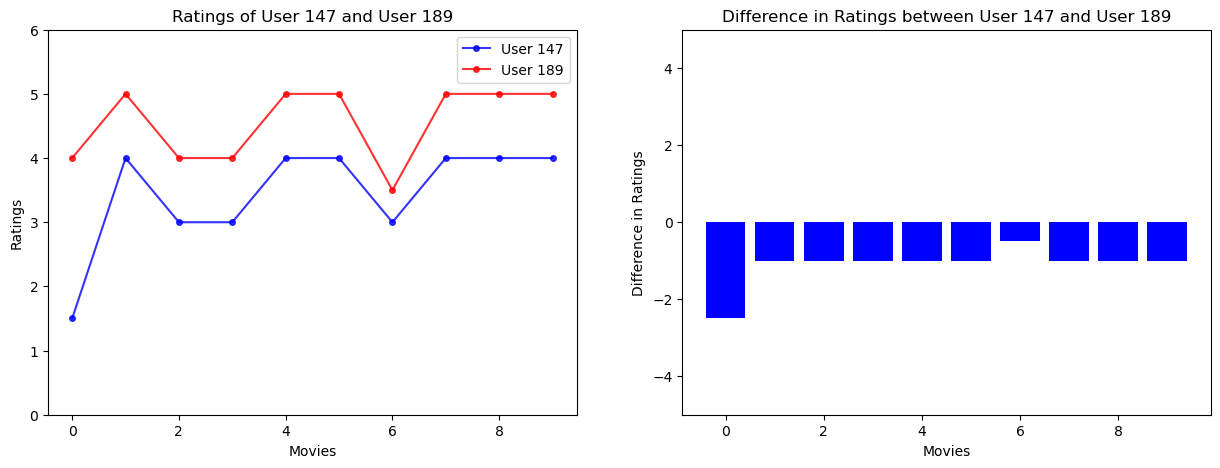

In [54]:
index_1 = 147
index_2 = 189

# calculate similarity of two
spearman_coeff = cf.similarity_spearman(ratings[index_1], ratings[index_2])
print(spearman_coeff)

pf.plotSimilarMovies(ratings, index_1, index_2)

At this point we should give some context about what the Spearman correlation coefficient actually quantifies. If we observe a high value for 2 users, that means for the movies they have both rated, the way they have rated them can be accurately described by a monotonic function. This means that if one user has rated, say 5 movies with 5 stars, and another user has rated the same movies with 3 stars, their correlation coefficient is still 1.

Take for example users 147 and 189, which have a correlation coefficient of 0.93, even though almost all of their ratings differ by at least 1 stars. So the spearman correlation coefficient is not a measure of how similar the ratings of the users actually are, but rather how well the overall relationship of the 2 users, can be monotonically described by a function.

Even if their ratings differ, if user 189 had rated a movie with 5 stars, which user 147 had not rated; we could make a very good guess that user 147 would rate the movie with 3 stars. This is because the overall relationship between the 2 users is very strong, and thus we can make a very good guess about the ratings of one user, based on the ratings of the other user.

Whilst this means that the spearman correlation coefficient is not the best measure to extract users with exact similar movie preferences, it is an excellent way to identify general relationships between the users. This is because, if we can accurately describe the relationship between the ratings of 2 users, then we can use that relationship to predict the ratings of one user, based on the ratings of the other user.

This is the basis of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), which does not require any knowledge about the users or  movies, but rather only the ratings of the users. It works on the principle, that similar users, in any sense, will rate movies in a similar way. Collaborative filtering is a very powerful technique that is a part of many modern sophisticated recommendation systems, and that interests many companies in the field of user-item recommendation like  [Netflix](https://en.wikipedia.org/wiki/Netflix_Prize).

Let's now plot the graph for a range of different correlation thresholds, to see how the graph changes.


In [35]:
# create 9 different graphs
# each time increasing in correlation threshold

corr_threshold_arr = np.linspace(0.9, 0.4, 9)
common_elem_threshold = 5

graphs = []

for i, corr_threshold in enumerate(corr_threshold_arr):
    # select nearest neighbors
    results = cf.select_best_neighbors(val_users, train_users, nearest_neighbors_union, corr_threshold=corr_threshold, p_value_threshold=0.05, min_common_elements=common_elem_threshold, full_results=False)

    # create a graph
    G = cf.create_graph(val_users, train_users, val_index, train_index, results)

    graphs.append(G)

Number of graphs: 9


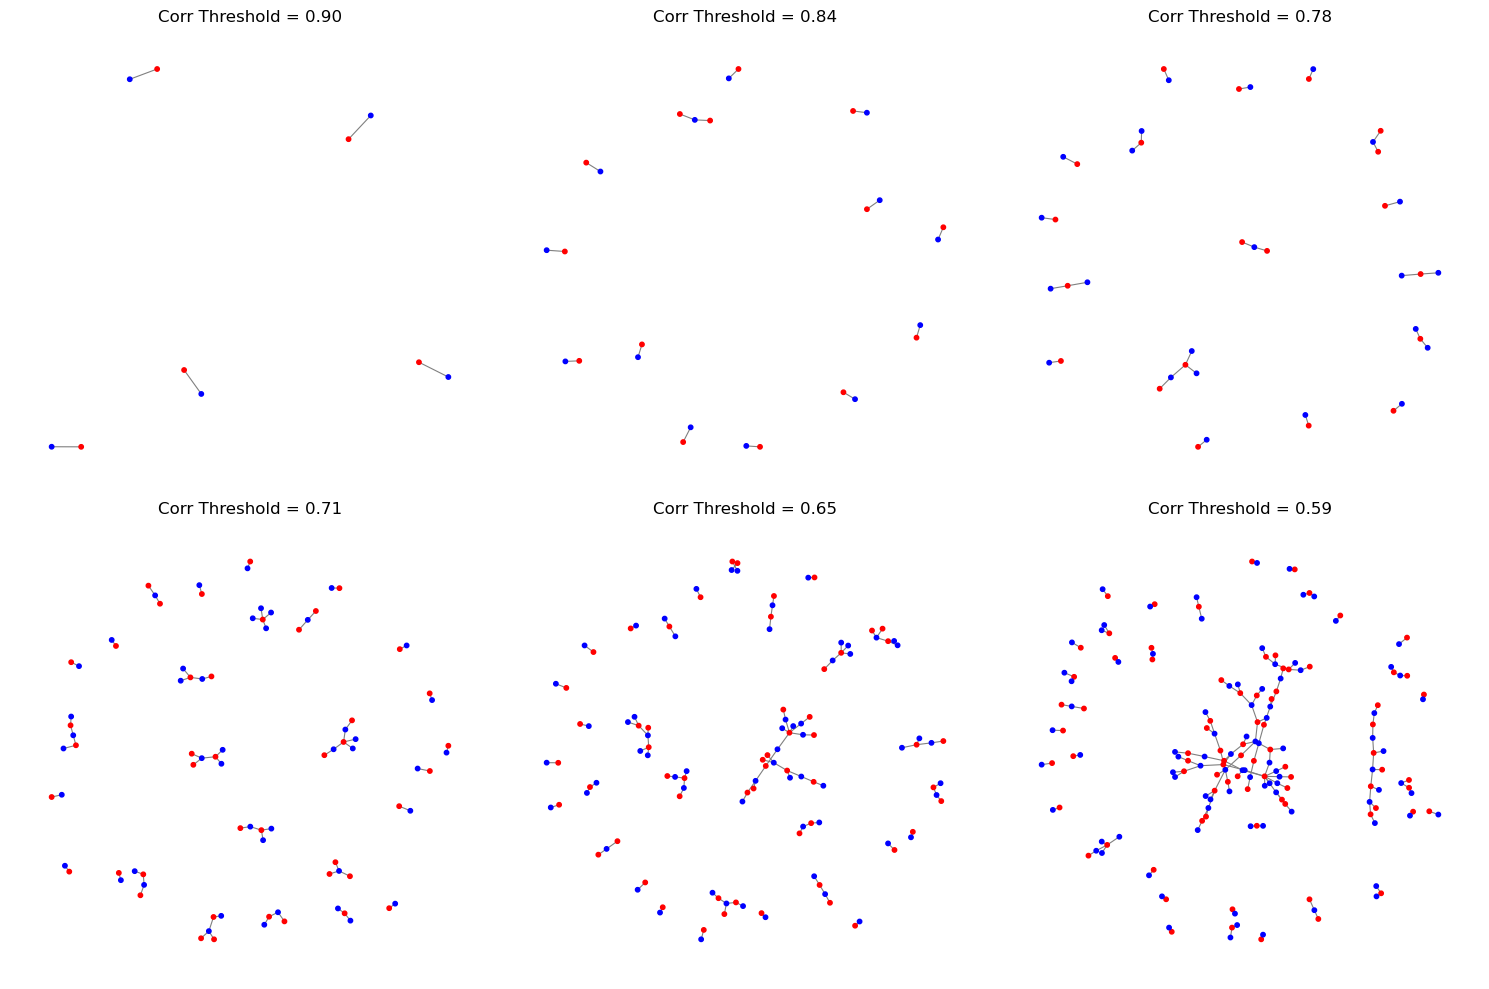

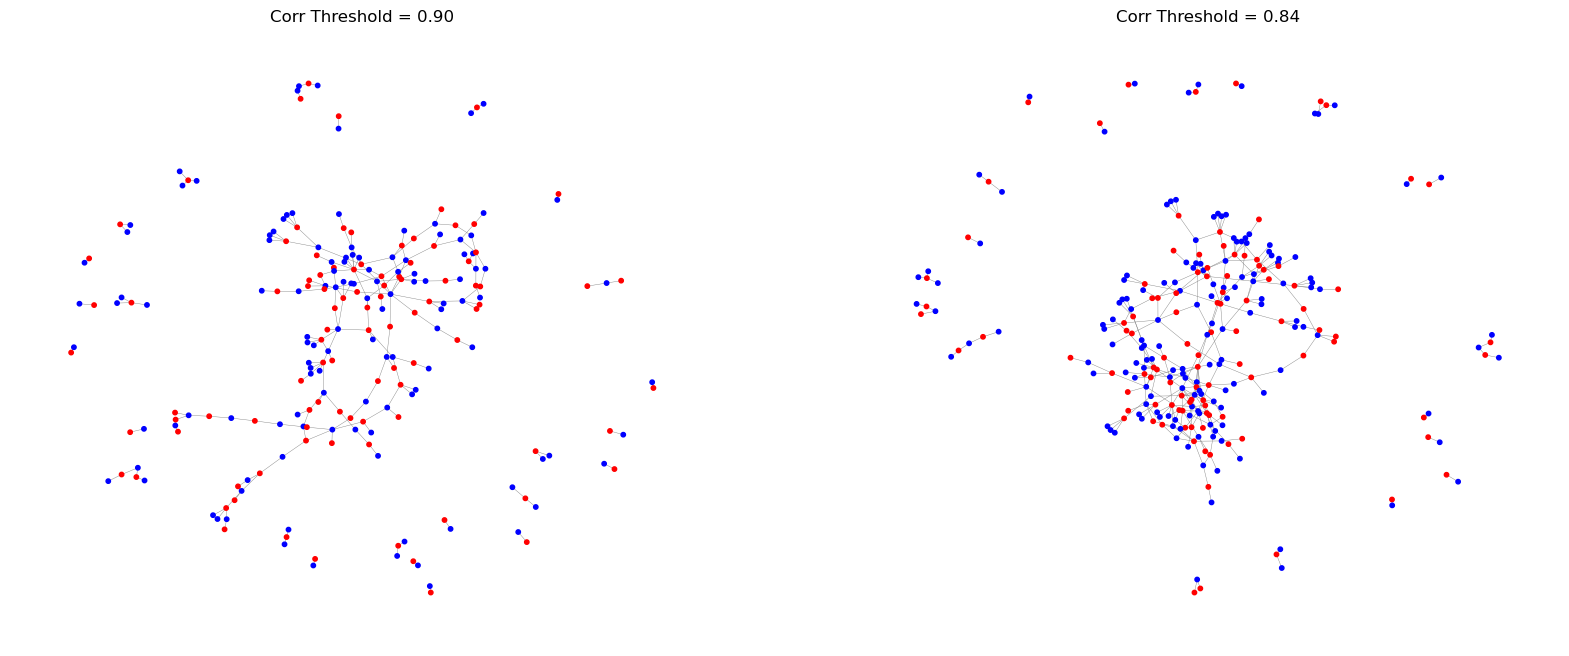

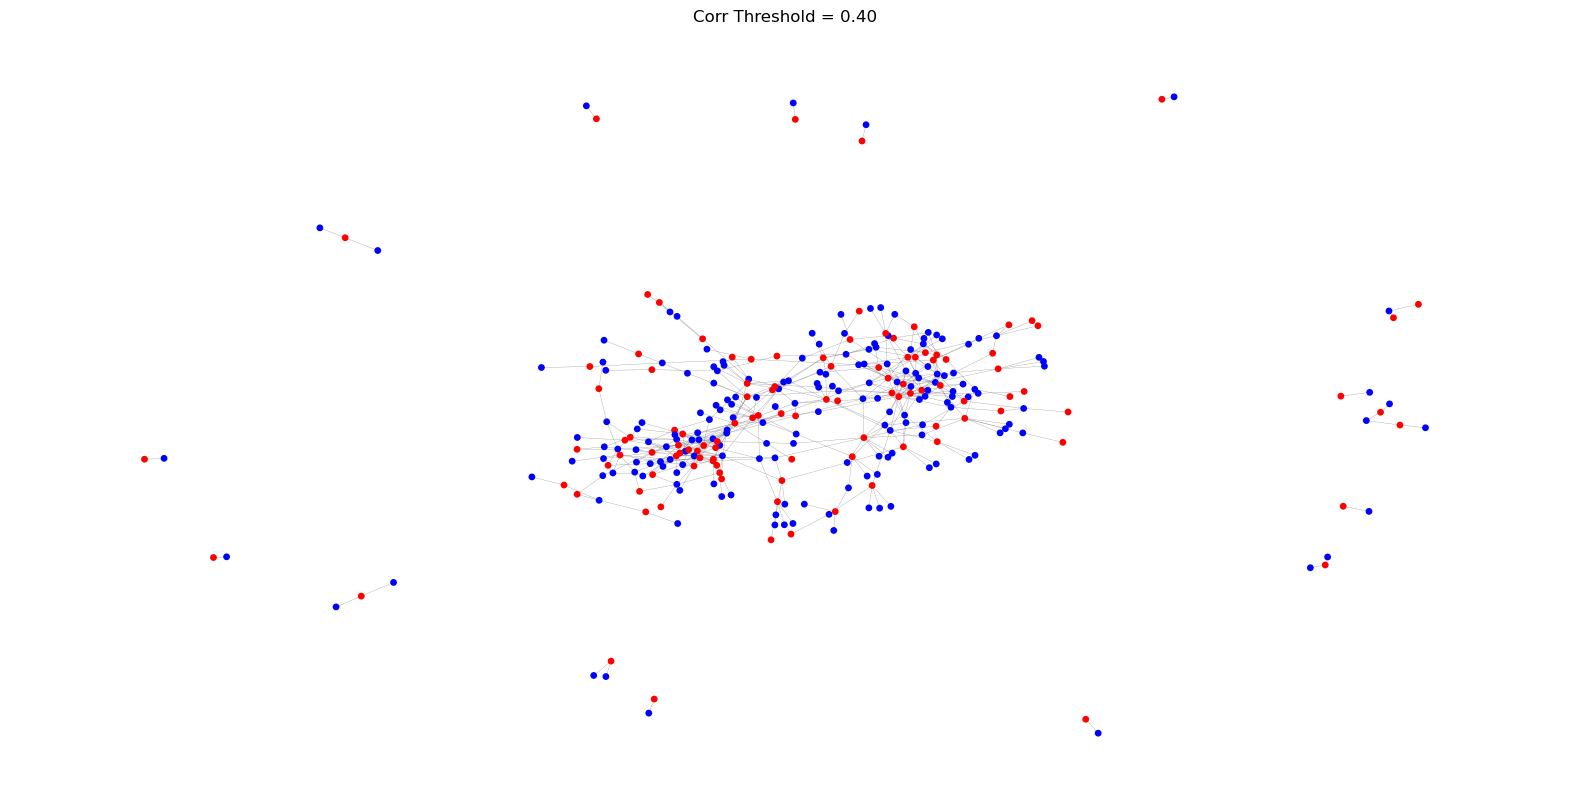

In [36]:
val_color = 'red'
train_color = 'blue'

pf.plot_graphs(graphs, corr_threshold_arr, val_index, train_color=train_color, val_color=val_color)

We observe that as the correlation threshold decreases, the number of edges in the graph increases. This means that as we decrease the correlation threshold, we are including more and more "weaker" relationships.

From this point on, there are many ways we can proceed. We can find the communities that are formed in the graph, we can explore the paths of each user to other user, we can identify key users that connect different communities, and many more.

Combining the communities, and the nodes they include, for the different values of the correlation threshold, we can build a sophisticated graph that connects all the users in the dataset, with weighted edges that represent the strength of the relationship between the users. The weight can be a combination of the relationships the users form depending on the correlation threshold. This graph can then be used to find the most similar users to a given user, and thus recommend movies to the user.

For the sake of brevity, we will just find and plot the number of nodes, components and articulation points in the graphs, for different values of the correlation threshold.

Graph 0: Node Count(Train:5  Val:5), Articul Points(Train:0  Val:0), Components: 5,
Graph 1: Node Count(Train:13  Val:14), Articul Points(Train:1  Val:0), Components: 13,
Graph 2: Node Count(Train:23  Val:20), Articul Points(Train:3  Val:5), Components: 17,
Graph 3: Node Count(Train:45  Val:42), Articul Points(Train:12  Val:11), Components: 27,
Graph 4: Node Count(Train:63  Val:56), Articul Points(Train:19  Val:19), Components: 32,
Graph 5: Node Count(Train:93  Val:83), Articul Points(Train:29  Val:37), Components: 37,
Graph 6: Node Count(Train:123  Val:98), Articul Points(Train:35  Val:49), Components: 27,
Graph 7: Node Count(Train:158  Val:106), Articul Points(Train:30  Val:51), Components: 22,
Graph 8: Node Count(Train:192  Val:113), Articul Points(Train:25  Val:50), Components: 17,


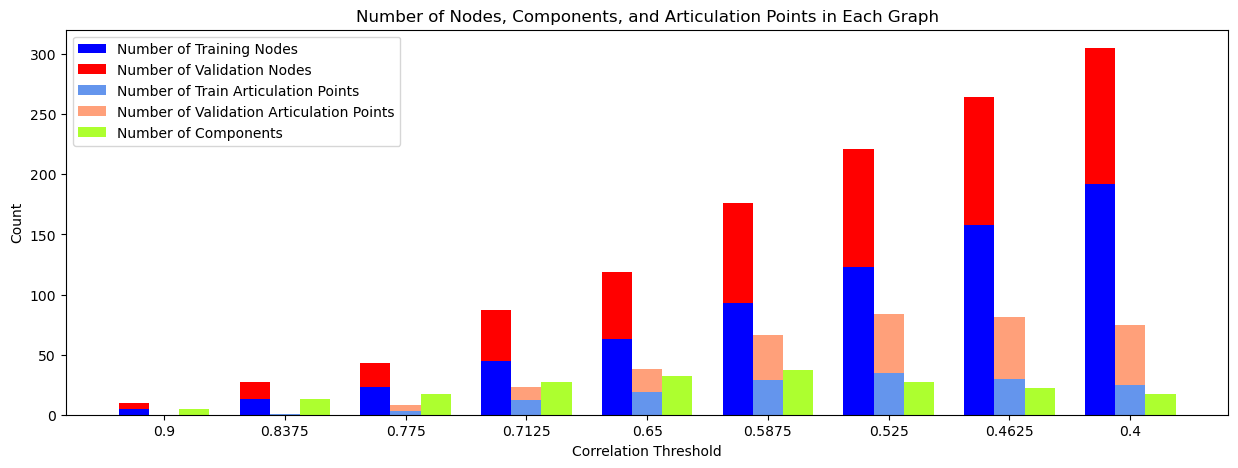

In [37]:
results = cf.find_graphs_info(graphs, val_index, print_results=True)
pf.plot_graphs_info(results, corr_threshold_arr)

We observe that as the correlation threshold decreases, the number of nodes and components increases, and the number of articulation points initally increases but seems to decrease in the end. This means that as we decrease the correlation threshold, we are including more and more "weaker" relationships, and thus the graph becomes more connected.

We should note that, even for a correlation threshold of 0.4, which is considered weak/moderate, the number of nodes missing is still high. Running the model for different train/validation users could fill the histogram more, but without eliminating the scenario where the users' preferences are too sparse/complex to be captured by this approach.




Let's see if calculating the spearman correlation coefficient of each validation user, for the whole training set, instead of the subset that was filtered by KNN. This approach will be slower, but may result in capturing more information about each validation user. One reason the subset we selected, may not be the best, is the fact that the dataset is very sparse and filled with 0's.

In [65]:
common_elem_threshold = 8
corr_threshold = 0.8


# Calculate spearman similarity for all val_users against all train_users
spearman_results = [[cf.similarity_spearman(val_user, curr_train_user, min_common_elements=common_elem_threshold) for curr_train_user in train_users] for val_user in val_users]

# Filter out None values and apply conditions for each val_user
filtered_indexes = [
    [index for index, result in enumerate(val_results) if result is not None and result.statistic > corr_threshold and result.pvalue < 0.05]
    for val_results in spearman_results
]

C:\Users\nikba\anaconda3\envs\pythonProject4\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


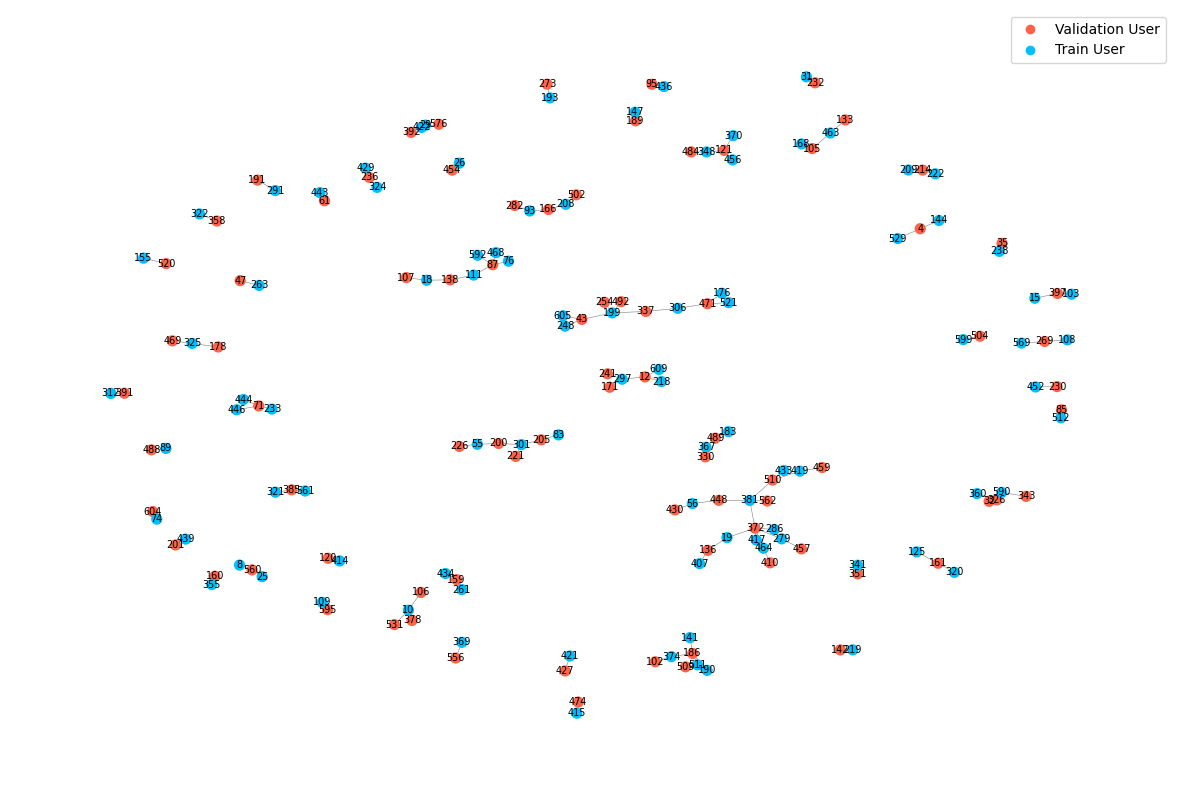

In [71]:
# construct a graph based on the filtered indexes results
big_G = cf.create_graph(val_users, train_users, val_index, train_index, filtered_indexes)
# plot the graph
pf.plotGraph(big_G, val_index)

SignificanceResult(statistic=0.8134892168199607, pvalue=0.0012875652402194984)
Ratio of movies with difference smaller than 0.5: 91.66666666666667%


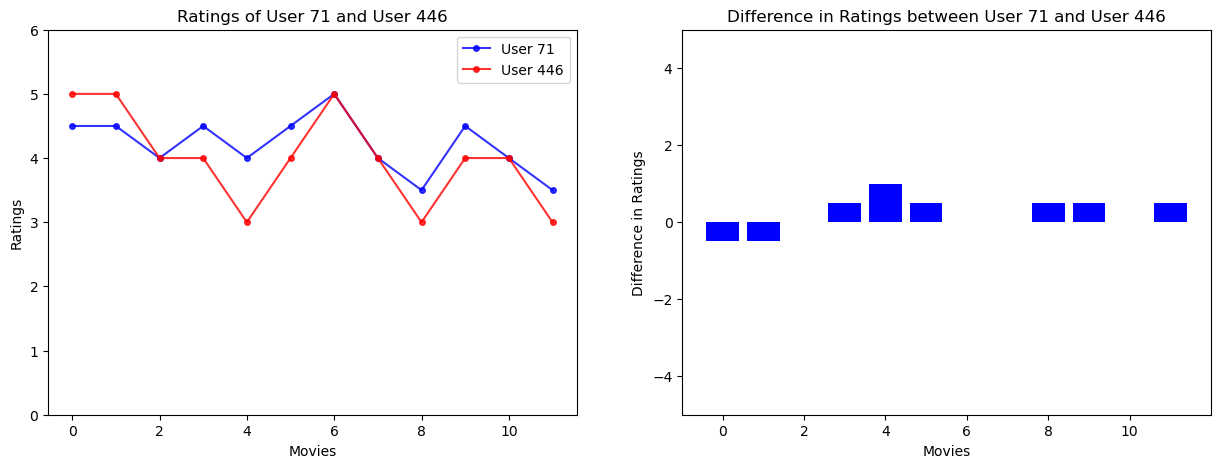

In [72]:
index_1 = 71
index_2 = 446

# calculate similarity of two
spearman_coeff = cf.similarity_spearman(ratings[index_1], ratings[index_2])
print(spearman_coeff)

pf.plotSimilarMovies(ratings, index_1, index_2)

Even for a higher correlation threshold, 0.8, and a higher minimum common of elements threshold, 8, we observe that the graph is way denser than with the previous approach. Although calculating the process is substantially more time expensive, it seems to be a better approach for this dataset.

Let's now plot the graph for a range of different correlation thresholds, to see how the graph changes.


Note: This takes some time to run

In [41]:
corr_threshold_arr = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
common_elem_threshold = 8

graphs = []

for i, corr_threshold in enumerate(corr_threshold_arr):
    # Calculate spearman similarity for all val_users against all train_users
    spearman_results = [[cf.similarity_spearman(val_user, curr_train_user, min_common_elements=common_elem_threshold) for curr_train_user in train_users] for val_user in val_users]

    # Filter out None values and apply conditions for each val_user
    filtered_indexes = [
        [index for index, result in enumerate(val_results) if result is not None and result.statistic > corr_threshold and result.pvalue < 0.05]
        for val_results in spearman_results
    ]

    # construct a graph based on the filtered indexes results
    G = cf.create_graph(val_users, train_users, val_index, train_index, filtered_indexes)

    graphs.append(G)

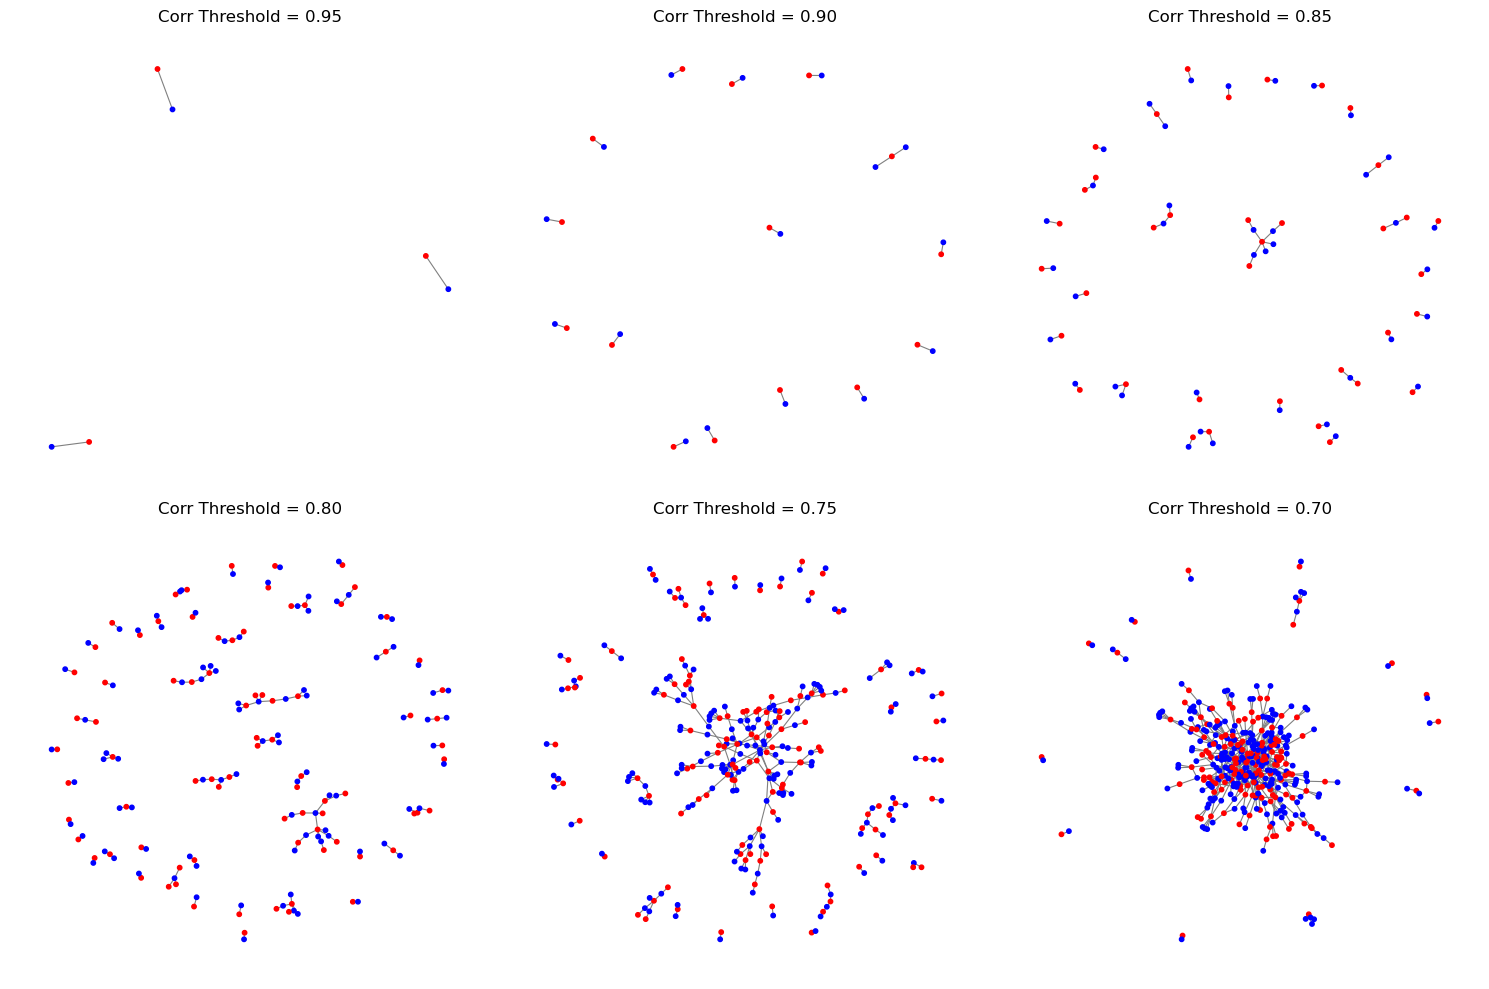

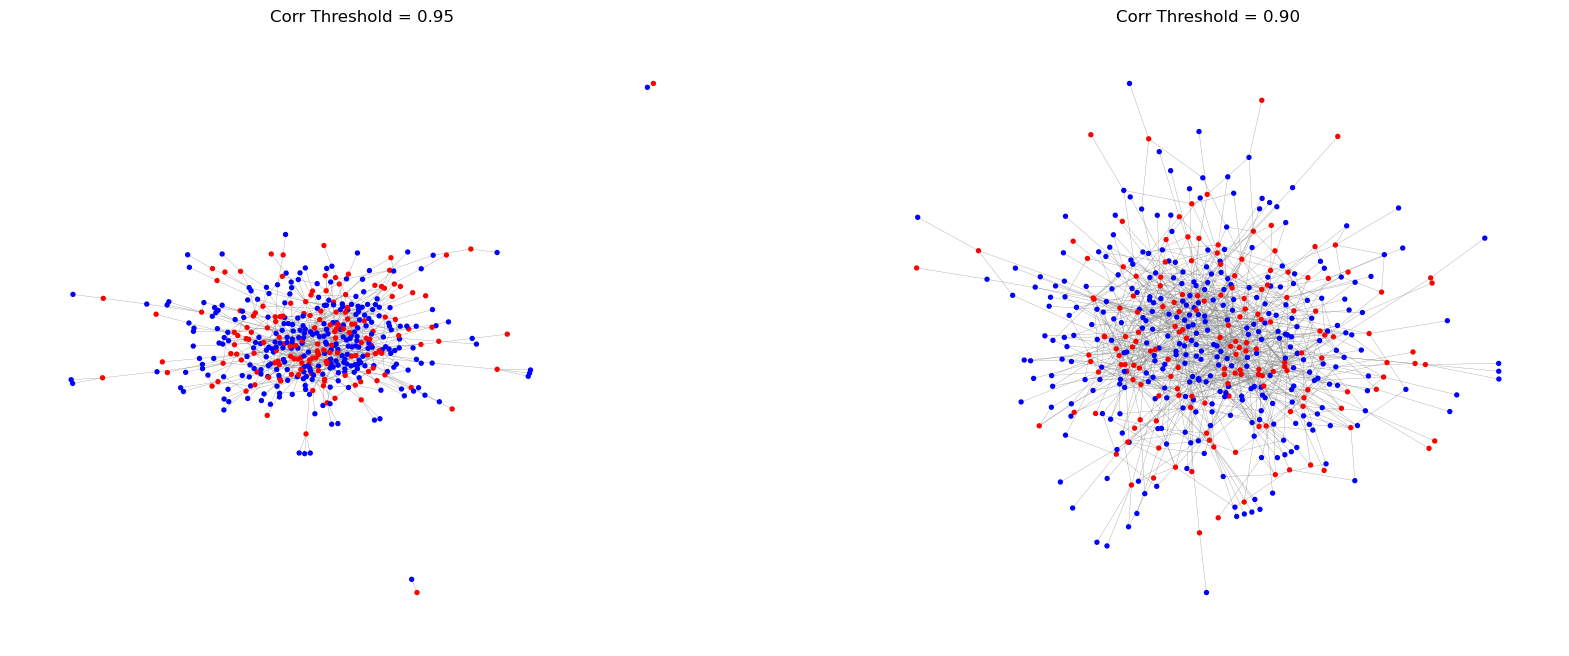

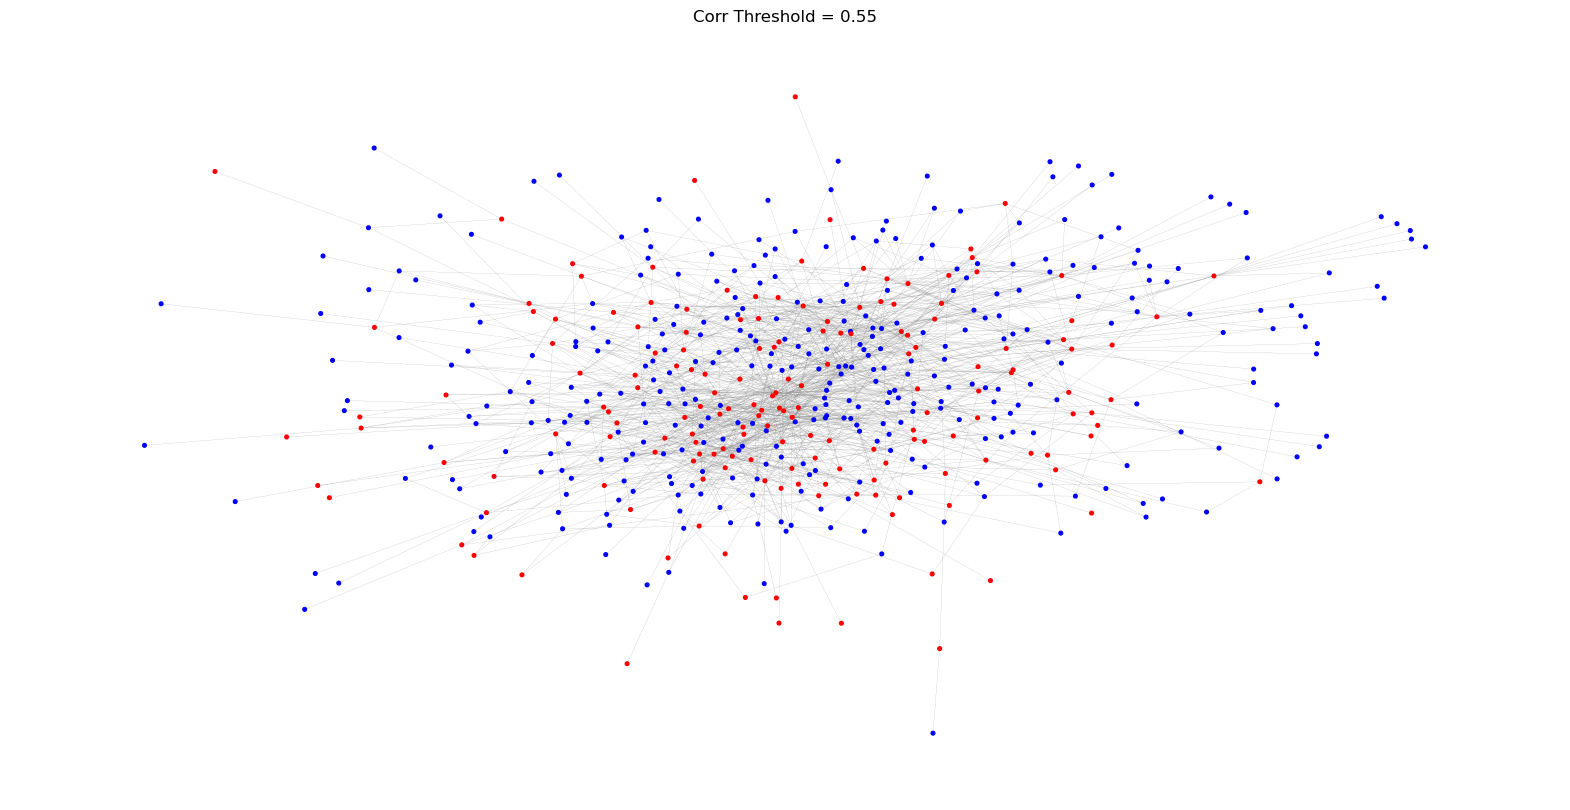

In [43]:
# plot the graphs
val_color = 'red'
train_color = 'blue'

pf.plot_graphs(graphs, corr_threshold_arr, val_index, train_color=train_color, val_color=val_color, node_sz=[10, 8, 7], edge_width=[0.8, 0.2, 0.1])

Graph 0: Node Count(Train:3  Val:3), Articul Points(Train:0  Val:0), Components: 3,
Graph 1: Node Count(Train:16  Val:15), Articul Points(Train:0  Val:1), Components: 15,
Graph 2: Node Count(Train:39  Val:37), Articul Points(Train:7  Val:6), Components: 30,
Graph 3: Node Count(Train:93  Val:82), Articul Points(Train:23  Val:27), Components: 52,
Graph 4: Node Count(Train:167  Val:120), Articul Points(Train:45  Val:61), Components: 41,
Graph 5: Node Count(Train:236  Val:146), Articul Points(Train:38  Val:65), Components: 15,
Graph 6: Node Count(Train:291  Val:162), Articul Points(Train:31  Val:70), Components: 3,
Graph 7: Node Count(Train:329  Val:168), Articul Points(Train:18  Val:54), Components: 1,
Graph 8: Node Count(Train:352  Val:171), Articul Points(Train:13  Val:51), Components: 1,


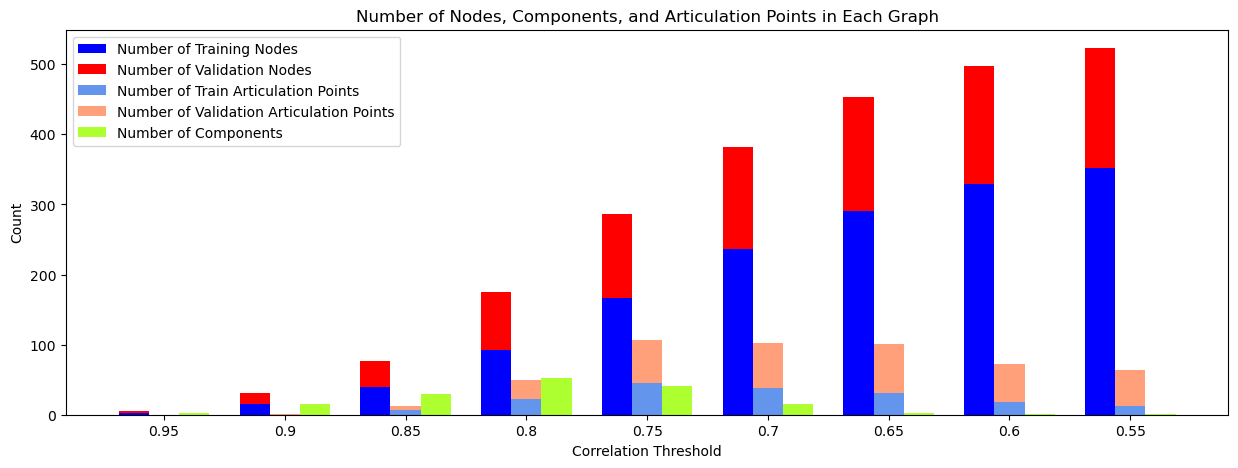

In [44]:
# plot histogram info
results = cf.find_graphs_info(graphs, val_index, print_results=True)

pf.plot_graphs_info(results, corr_threshold_arr)

Looking at the graph, we can now actually see the difference in computing the correlation between a validation user and the whole training set vs the correlation between a validation user and the subset of the training set. The graph is much denser, and the number of nodes missing is much lower. Even with a weaker correlation like 0.55, there are still some validation users meaning. This suggests that the not included users, have more unique movie preferences.

We should also note that the last 2 graphs have 1 component, meaning that all the users are connected.

Let's repeat the process for a smaller minimum common elements threshold, to see if we can capture these more niche relationships.

Note: This takes some more time to run

In [86]:
corr_threshold_arr = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
common_elem_threshold = 5

positive_graphs = []

for i, corr_threshold in enumerate(corr_threshold_arr):
    # Calculate spearman similarity for all val_users against all train_users
    spearman_results = [[cf.similarity_spearman(val_user, curr_train_user, min_common_elements=common_elem_threshold) for curr_train_user in train_users] for val_user in val_users]

    # Filter out None values and apply conditions for each val_user
    filtered_indexes = [
        [index for index, result in enumerate(val_results) if result is not None and result.statistic > corr_threshold and result.pvalue < 0.05]
        for val_results in spearman_results
    ]

    # construct a graph based on the filtered indexes results
    G = cf.create_graph(val_users, train_users, val_index, train_index, filtered_indexes)

    positive_graphs.append(G)

C:\Users\nikba\anaconda3\envs\pythonProject4\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


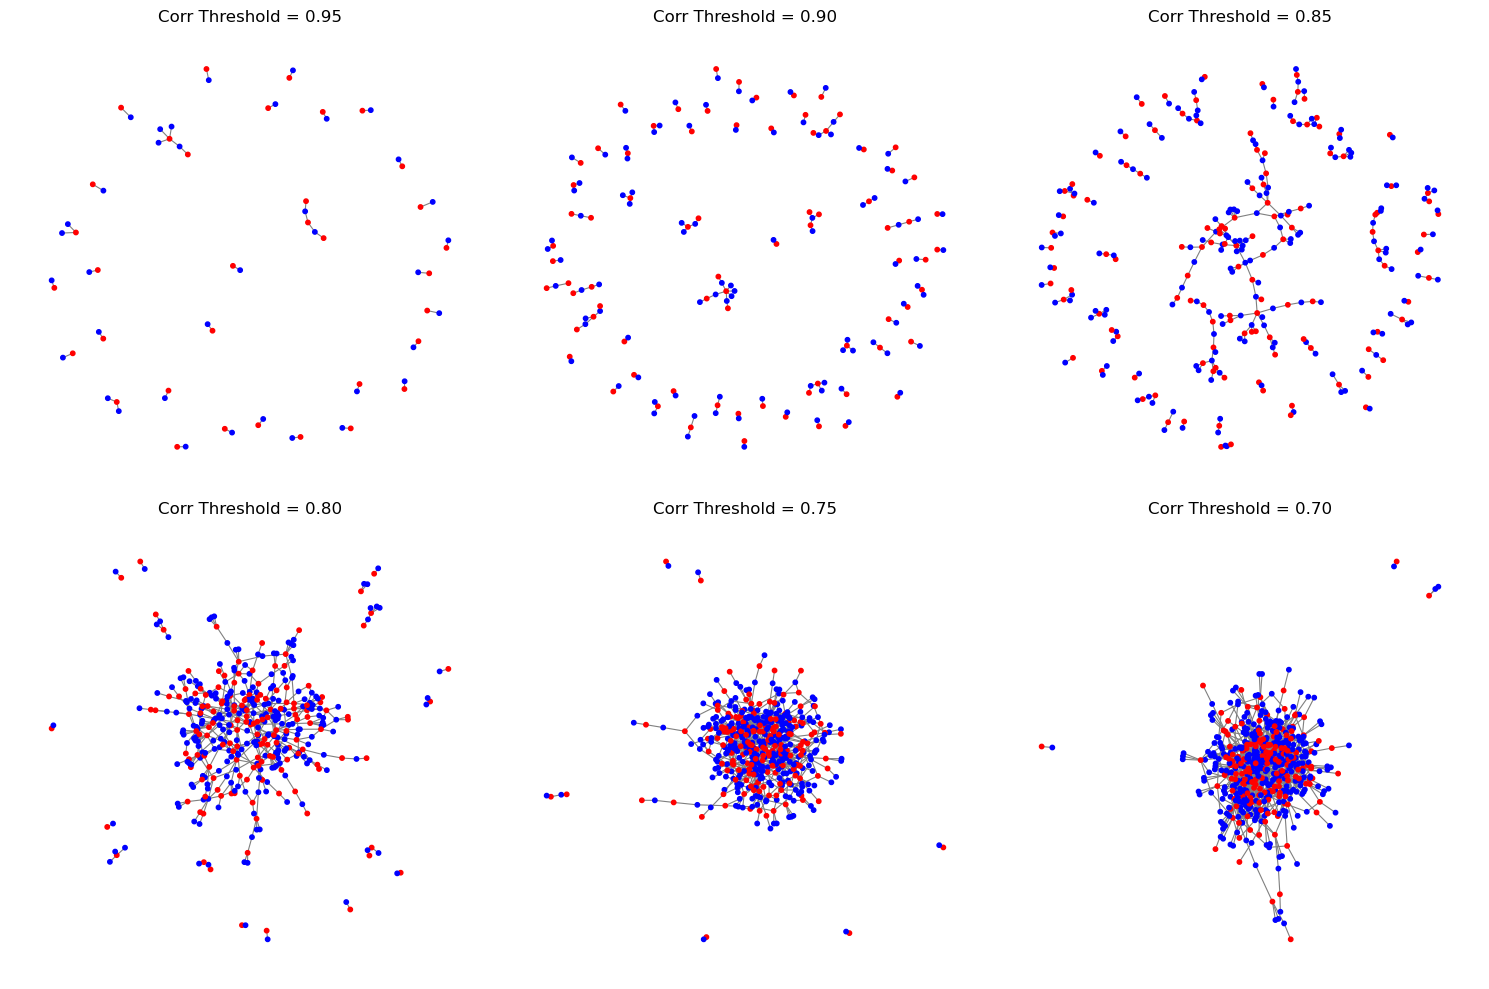

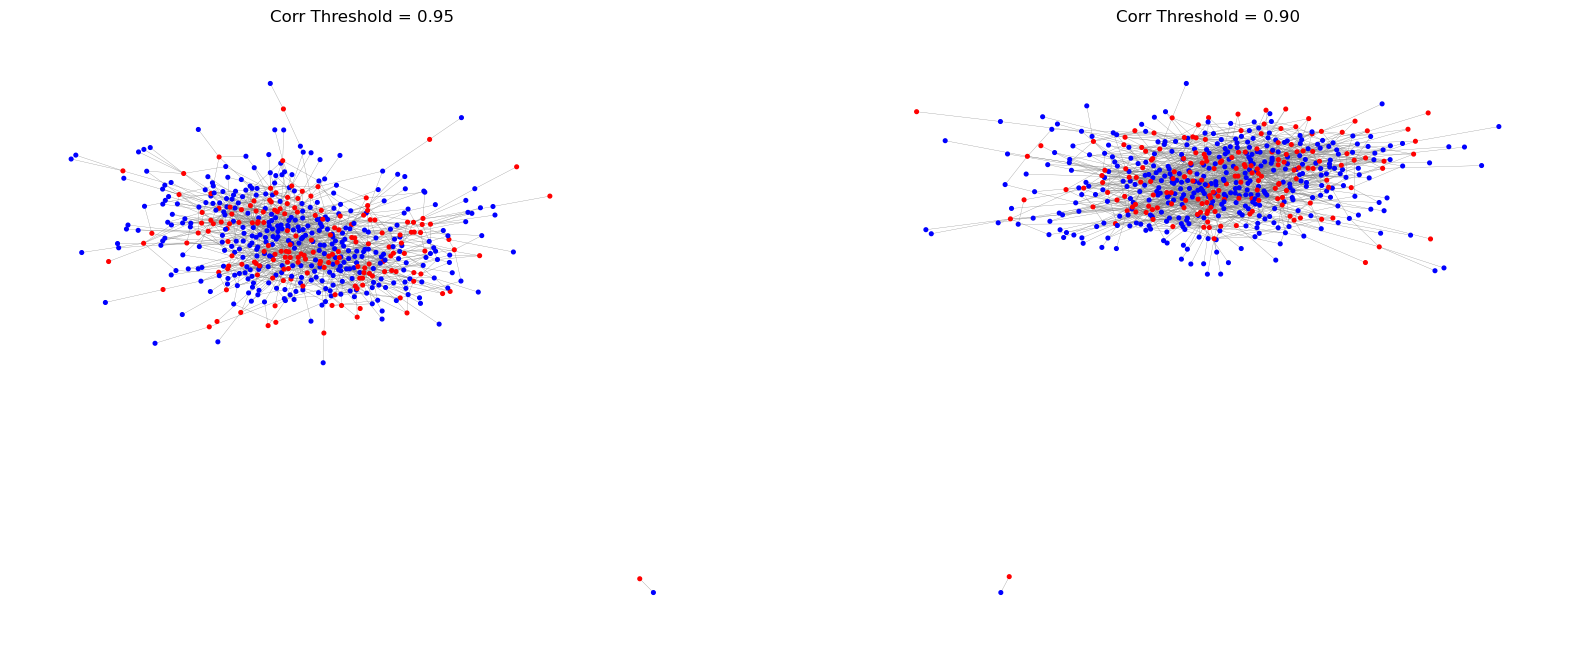

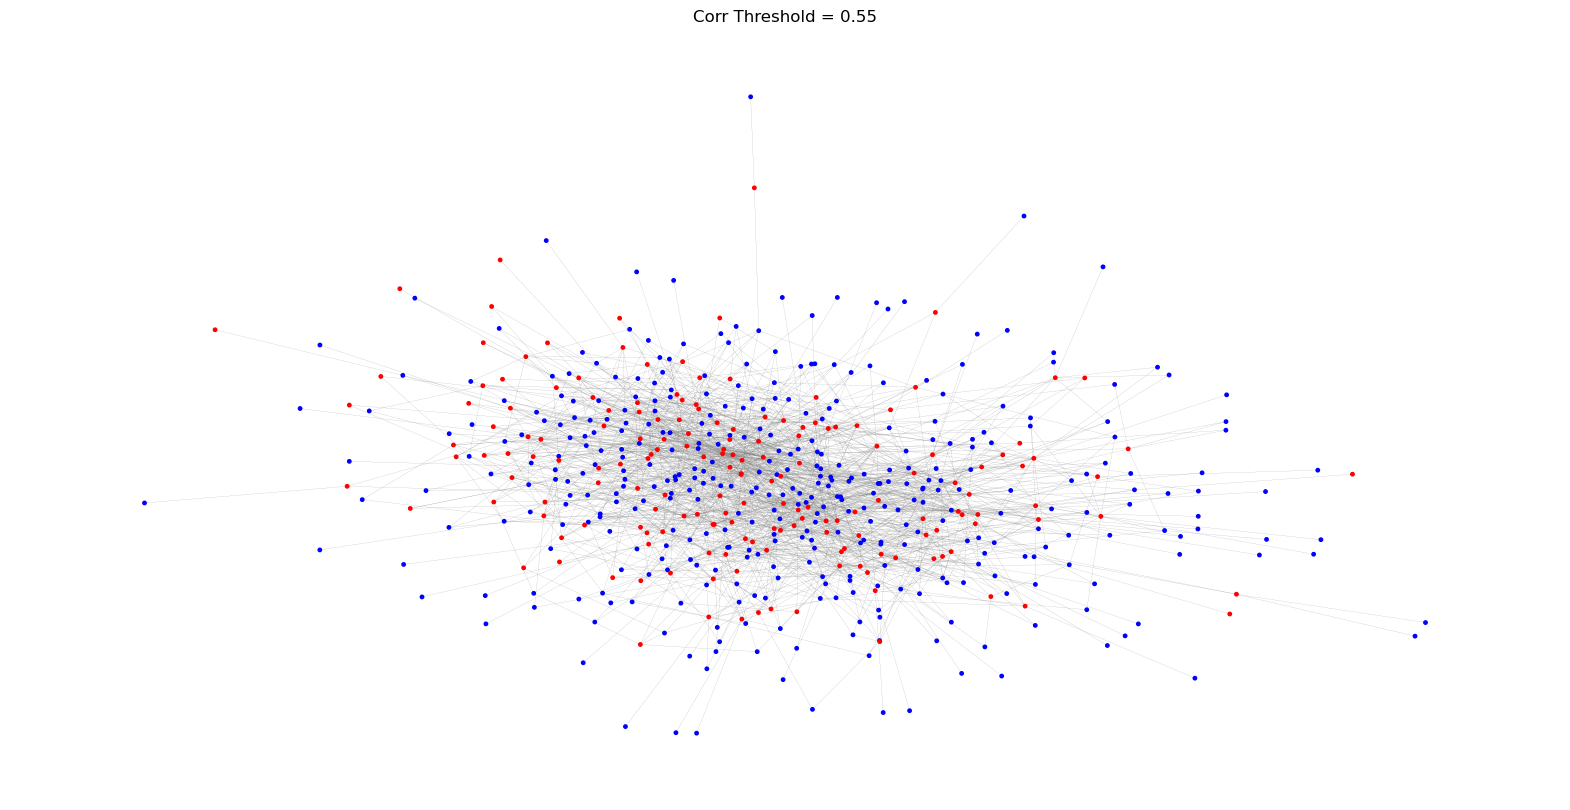

In [87]:
# plot graphs
val_color = 'red'
train_color = 'blue'

pf.plot_graphs(positive_graphs, corr_threshold_arr, val_index, train_color=train_color, val_color=val_color, node_sz=[10, 7, 6], edge_width=[0.8, 0.2, 0.1])

Graph 0: Node Count(Train:37  Val:34), Articul Points(Train:3  Val:4), Components: 31,
Graph 1: Node Count(Train:93  Val:77), Articul Points(Train:14  Val:21), Components: 62,
Graph 2: Node Count(Train:170  Val:124), Articul Points(Train:53  Val:67), Components: 57,
Graph 3: Node Count(Train:259  Val:153), Articul Points(Train:50  Val:90), Components: 18,
Graph 4: Node Count(Train:308  Val:165), Articul Points(Train:30  Val:87), Components: 7,
Graph 5: Node Count(Train:345  Val:170), Articul Points(Train:18  Val:75), Components: 4,
Graph 6: Node Count(Train:363  Val:173), Articul Points(Train:12  Val:67), Components: 2,
Graph 7: Node Count(Train:375  Val:175), Articul Points(Train:5  Val:47), Components: 2,
Graph 8: Node Count(Train:390  Val:176), Articul Points(Train:6  Val:51), Components: 1,


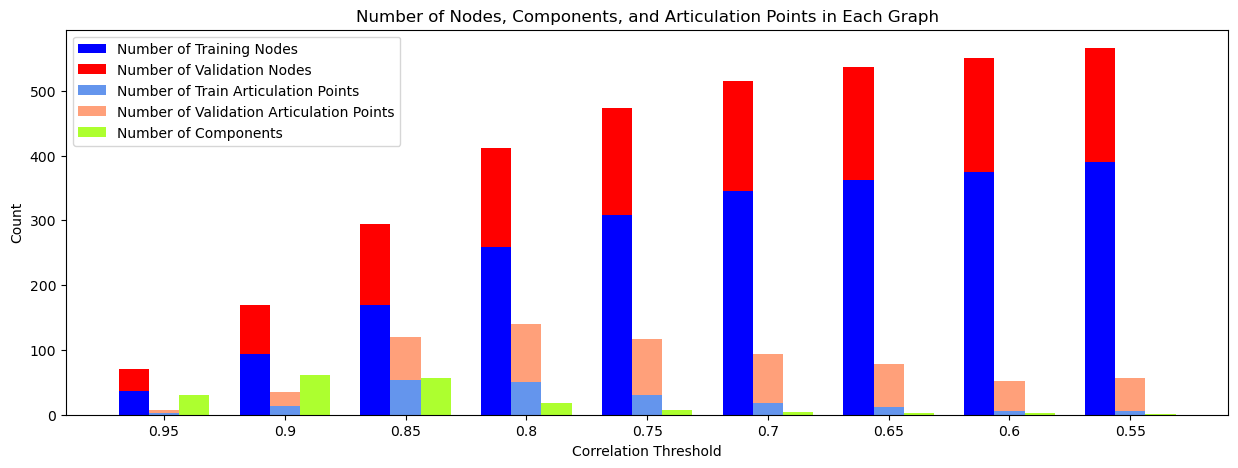

In [88]:
# plot histogram info
results = cf.find_graphs_info(positive_graphs, val_index, print_results=True)

pf.plot_graphs_info(results, corr_threshold_arr)

We see that when we decrease the intersection threshold, we include some more relationships to the graph, resulting in a total of 7 validation nodes missing. This means that there are 7 validation users that do not have a relationship with any of the training users, that meet the correlation threshold.

# **Negative Relationships**

We have so far analyzed the relationships between the users, that are positively correlated. We can also analyze the relationships between the users, that are negatively correlated. This can be done by simply changing the correlation threshold, to a negative value.

A negative correlation means that as one variable increases, the other decreases. In our case, this means that as one user rates a movie with a high rating, the other user rates the same movie with a low rating. This means that the users have opposite preferences, and thus we can use this information to better model the relationships between users.

In [76]:
common_elem_threshold = 5
corr_threshold = -0.8


# Calculate spearman similarity for all val_users against all train_users
spearman_results = [[cf.similarity_spearman(val_user, curr_train_user, min_common_elements=common_elem_threshold) for curr_train_user in train_users] for val_user in val_users]

# Filter out None values and apply conditions for each val_user
filtered_indexes = [
    [index for index, result in enumerate(val_results) if result is not None and result.statistic < corr_threshold and result.pvalue < 0.05]
    for val_results in spearman_results
]

C:\Users\nikba\anaconda3\envs\pythonProject4\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


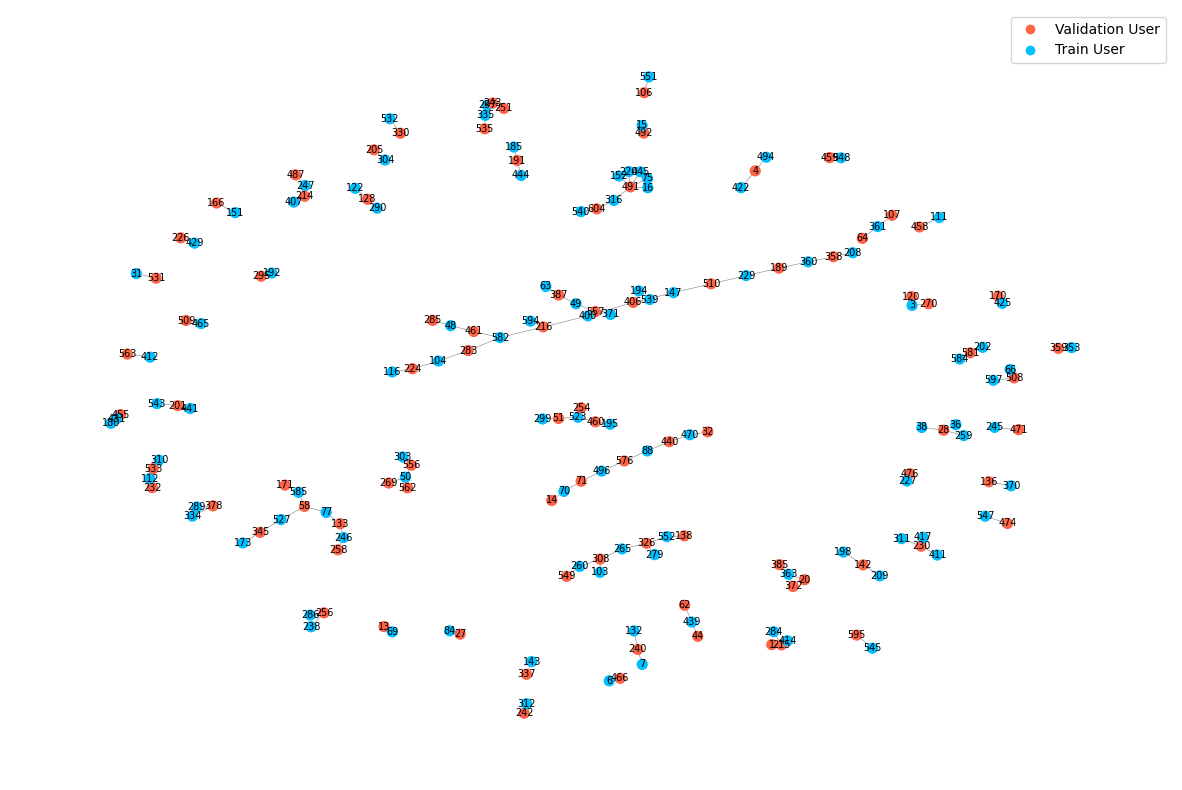

In [77]:
# construct a graph based on the filtered indexes results
negative_G = cf.create_graph(val_users, train_users, val_index, train_index, filtered_indexes)
# plot the graph
pf.plotGraph(negative_G, val_index)

SignificanceResult(statistic=-0.8349908101841637, pvalue=0.019396010964030132)
Ratio of movies with difference smaller than 0.5: 14.285714285714286%


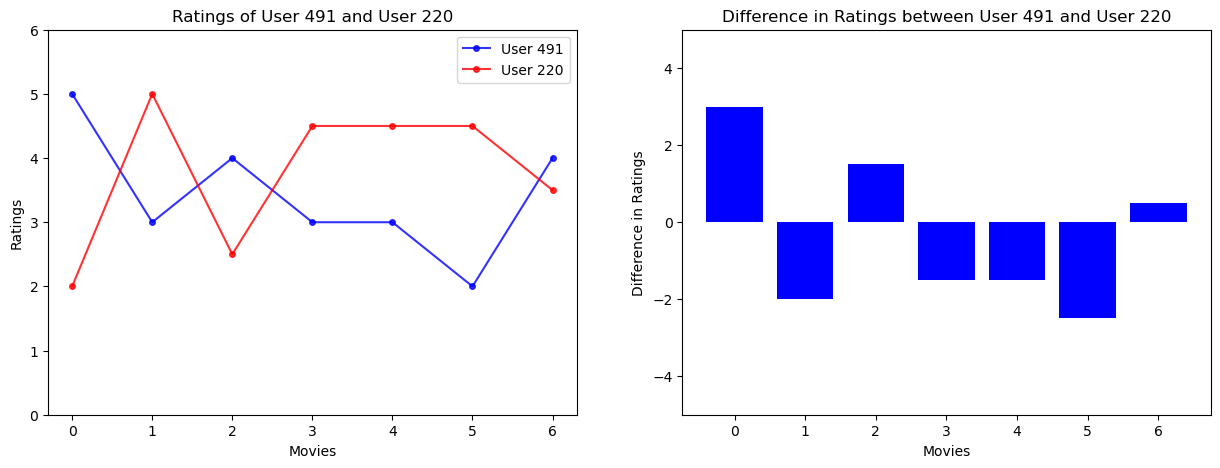

In [100]:
index_1 = 491
index_2 = 220

# calculate similarity of two
spearman_coeff = cf.similarity_spearman(ratings[index_1], ratings[index_2])
print(spearman_coeff)

pf.plotSimilarMovies(ratings, index_1, index_2)

In [90]:
corr_threshold_arr = [-0.95, -0.9, -0.85, -0.8, -0.75, -0.7, -0.65, -0.6, -0.55]

negative_graphs = []

for i, corr_threshold in enumerate(corr_threshold_arr):
    # Calculate spearman similarity for all val_users against all train_users
    spearman_results = [[cf.similarity_spearman(val_user, curr_train_user, min_common_elements=common_elem_threshold) for curr_train_user in train_users] for val_user in val_users]

    # Filter out None values and apply conditions for each val_user
    filtered_indexes = [
        [index for index, result in enumerate(val_results) if result is not None and result.statistic < corr_threshold and result.pvalue < 0.05]
        for val_results in spearman_results
    ]

    # construct a graph based on the filtered indexes results
    G = cf.create_graph(val_users, train_users, val_index, train_index, filtered_indexes)

    negative_graphs.append(G)


C:\Users\nikba\anaconda3\envs\pythonProject4\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


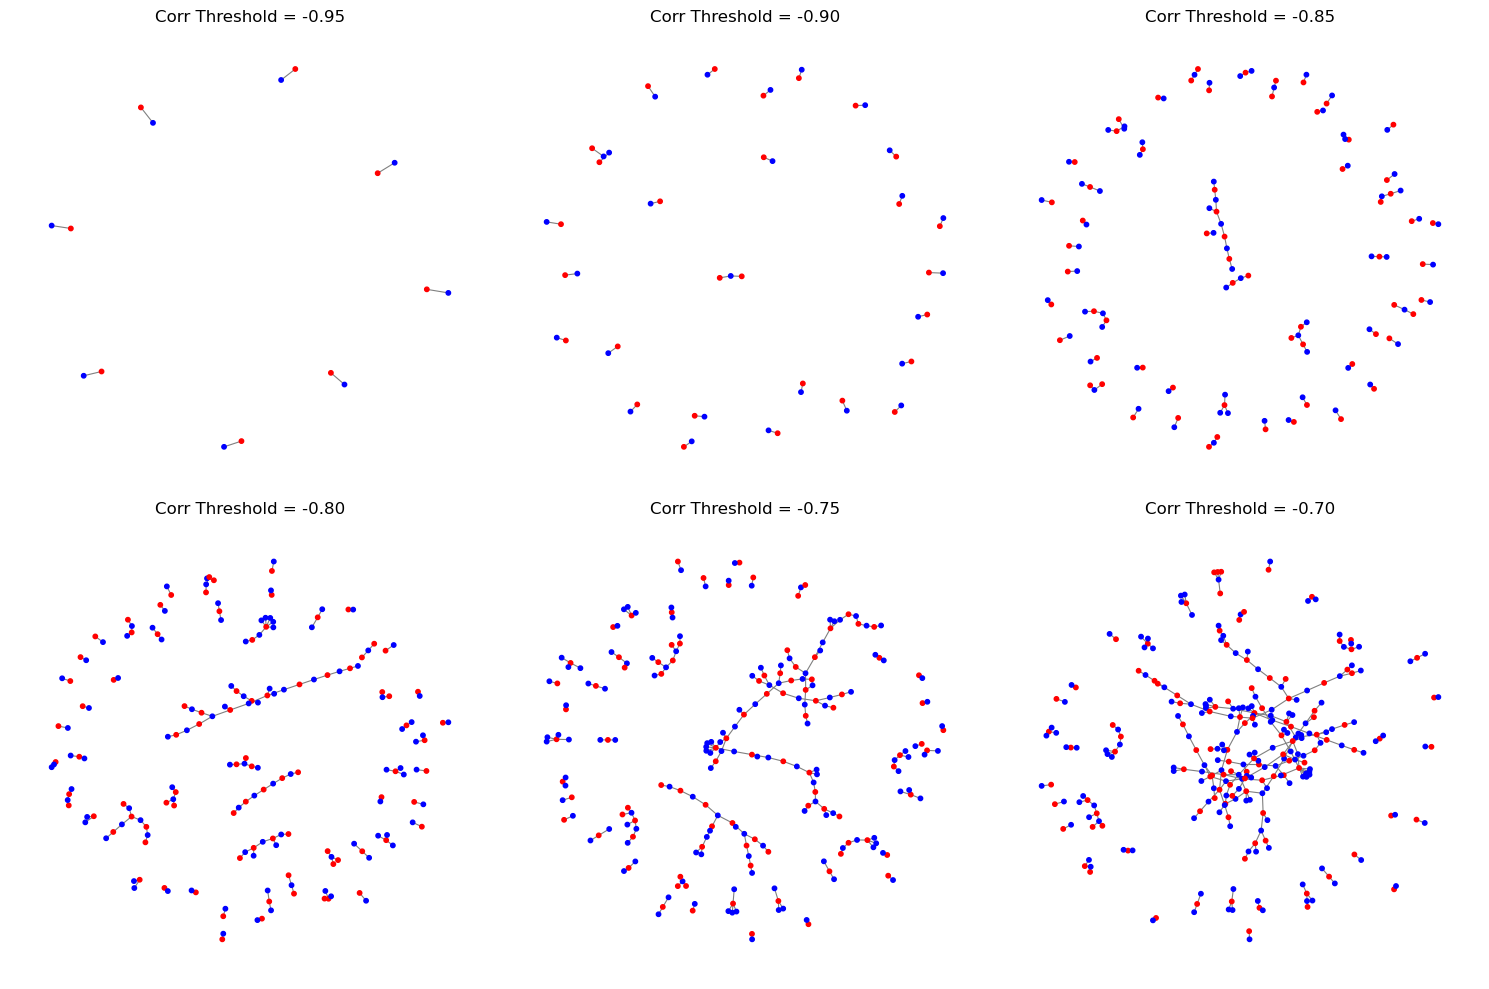

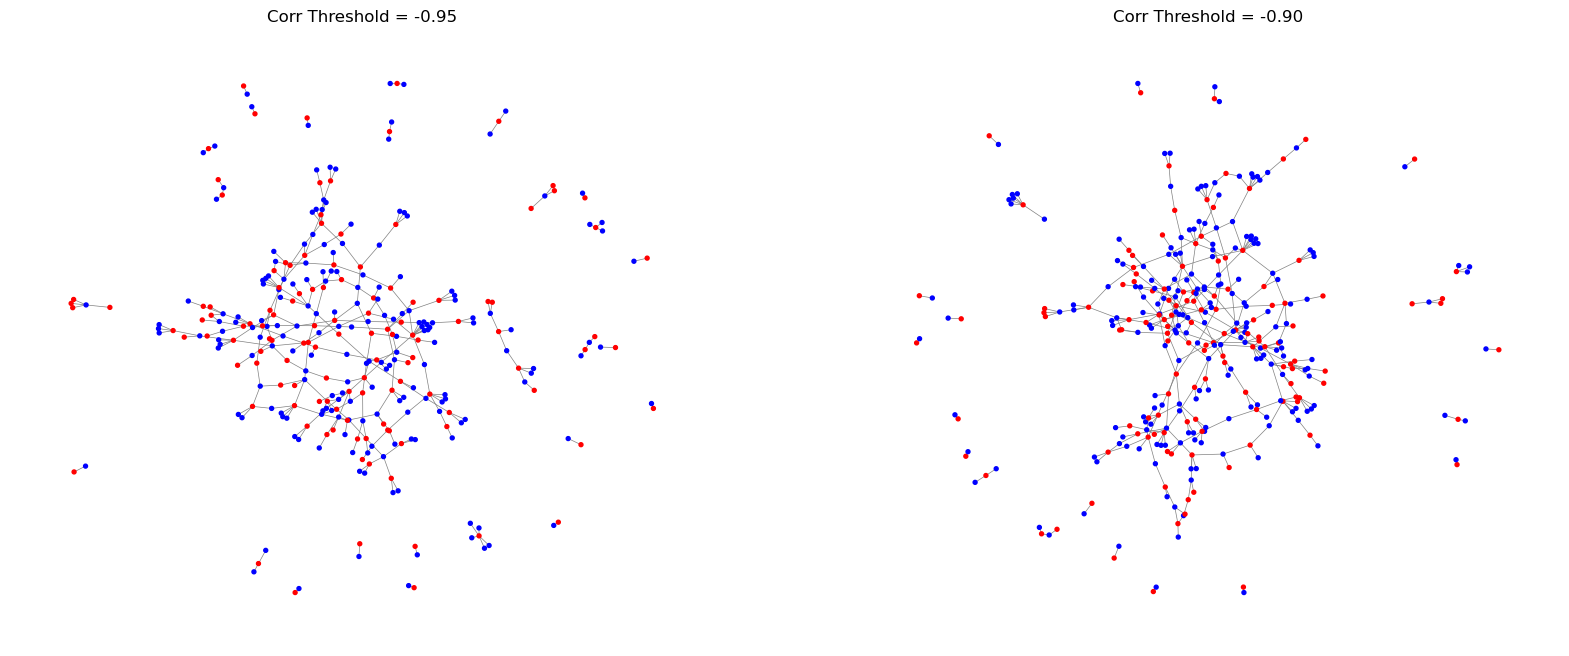

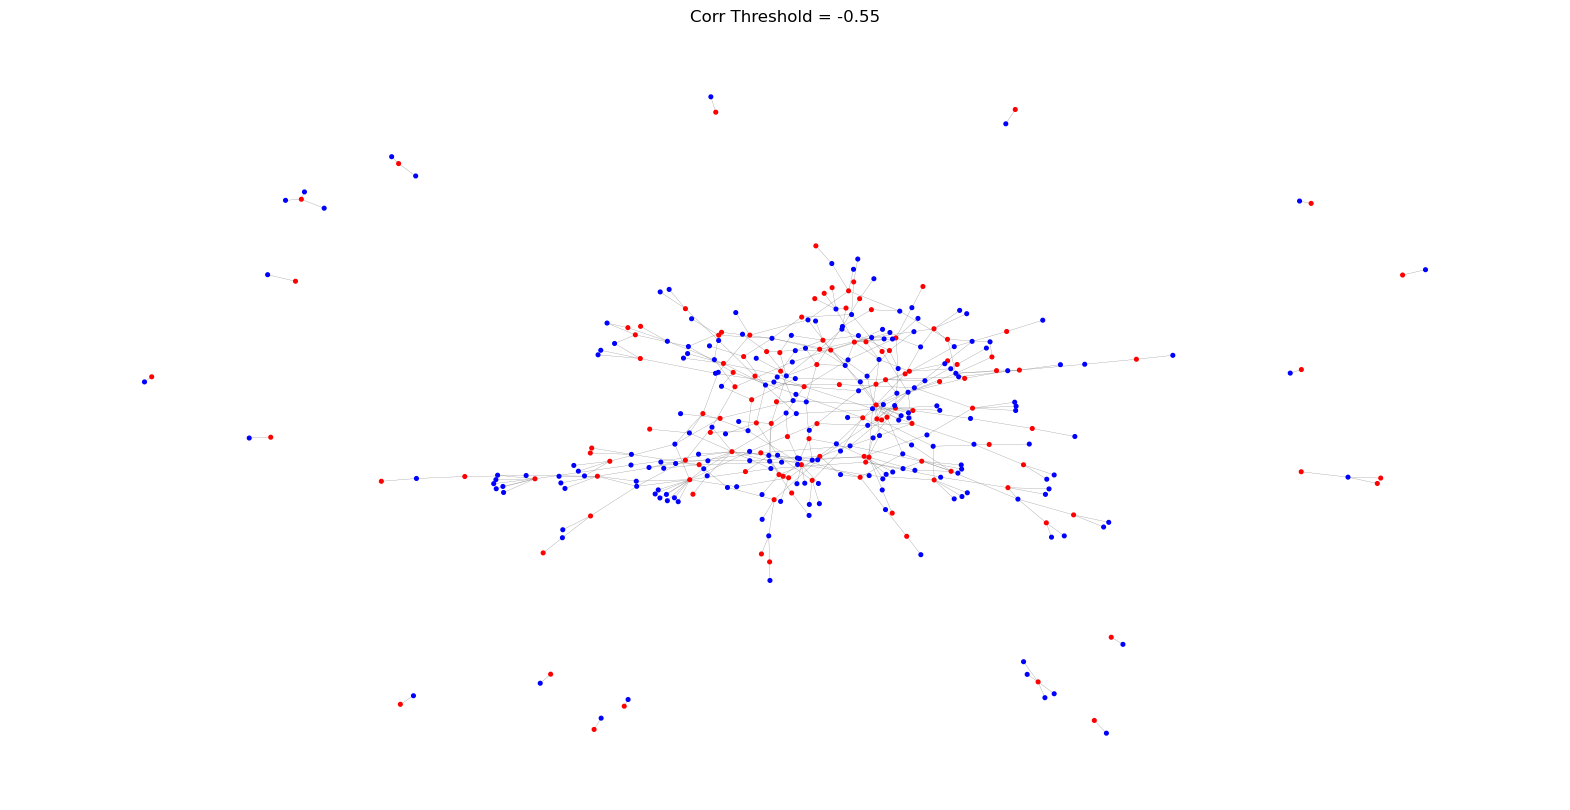

In [91]:
# plot graphs
val_color = 'red'
train_color = 'blue'

pf.plot_graphs(negative_graphs, corr_threshold_arr, val_index, train_color=train_color, val_color=val_color, node_sz=[10, 8, 7], edge_width=[0.8, 0.5, 0.2])

Graph 0: Node Count(Train:8  Val:8), Articul Points(Train:0  Val:0), Components: 8,
Graph 1: Node Count(Train:27  Val:28), Articul Points(Train:1  Val:0), Components: 27,
Graph 2: Node Count(Train:70  Val:64), Articul Points(Train:12  Val:17), Components: 51,
Graph 3: Node Count(Train:105  Val:88), Articul Points(Train:29  Val:38), Components: 55,
Graph 4: Node Count(Train:139  Val:96), Articul Points(Train:41  Val:62), Components: 45,
Graph 5: Node Count(Train:173  Val:114), Articul Points(Train:48  Val:71), Components: 37,
Graph 6: Node Count(Train:193  Val:124), Articul Points(Train:39  Val:69), Components: 27,
Graph 7: Node Count(Train:212  Val:132), Articul Points(Train:40  Val:70), Components: 23,
Graph 8: Node Count(Train:227  Val:134), Articul Points(Train:35  Val:68), Components: 19,


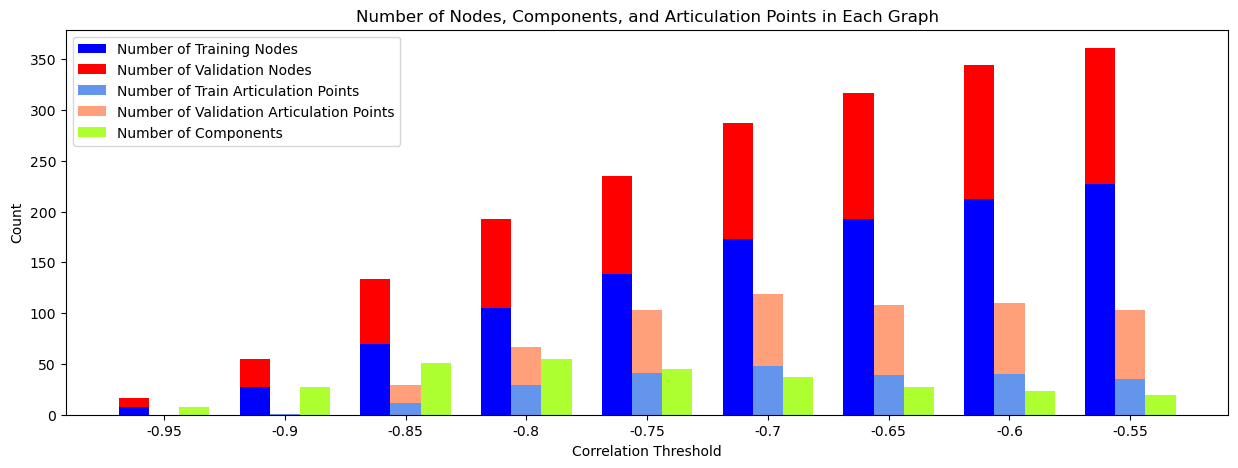

In [92]:
# plot histogram info
results = cf.find_graphs_info(negative_graphs, val_index, print_results=True)

pf.plot_graphs_info(results, corr_threshold_arr)

## **Conclusion**

Summarizing our work so far, we have,
 1. Loaded the dataset
 2. Created a ratings matrix
 3. Split the ratings matrix into train and validation sets
 4. Applied PCA to the train set, to reduce the dimensionality of the dataset
 5. Projected the validation set onto the components of the training set
 6. Calculated the nearest neighbors for each user in the validation set, using 2 different methods, euclidean distance and cosine similarity
 7. Filtered the relationships that are loosely correlated, using a correlation threshold and a p-value threshold
 8. Constructed a graph, where each node is a user, and each edge is a relationship between 2 users
 9. Plotted the graph for a range of different correlation thresholds, to see how the graph changes
 10. Found and plotted the number of nodes, components and articulation points in the graphs, for different values of the correlation threshold

We have done an extensive analysis on the dataset, and we have identified relationships between the users, that can be used to recommend movies to users. We have also identified the relationships that are statistically significant, and thus we can be sure that the relationships we have identified are not random.

We can conclude that calculating the correlation metric for each validation user, against the whole training set, is a better approach than calculating the correlation metric for each validation user, against a subset of the training set. This is because the dataset is very sparse, and thus the subset of the training set, may not be the best representation of the user's preferences. After calculating these relationships, we can do some graph analysis, and based on those use a KNN algorithm to find the most similar users.

To take this a step further, we would perform a similar analysis, for all the movies. We would try to build relationships, based on their genres, the audience that enjoys them, to identify movies that are similar to each other.

We could then, further analyze the profile of each user, by identifying what genres of related movies they enjoy, how strict are they in their ratings, how many movies they have rated, and many more. This would allow us to build a more sophisticated recommendation system, that would be able to recommend movies to users, based on their profile, and the profile of the movies.

Having all these ideas implemented, we would effectively have mapped the relationships between the users and the movies, and thus we would be able to recommend movies to users, based on their profile, their peers' profile, the profile of the movies and the relationships between the users and the movies.


